### Importing Libraries 

In [1]:
import model_build_marineheatwaves as mhw_mb
import exploratory_data_analysis_mhw_script as eda
import numpy as np

#### Default Parameters Defining

In [2]:
n_lag = 7
n_features = 2
n_seq = 7
epochs = 200
batch_size = 128

### Bay of Bengal Region

##### Model Training 

(10944, 7, 2)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 64)             320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 192)               0         
                                                                 
 dense (Dense)               (None, 7)                 1351      
                                                                 
Total params: 1,671
Trainable params: 1,671
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
86/86 [==============================] - 1s 7ms/step - loss: 0.1325 - val_loss: 0.0452
Epoch 2

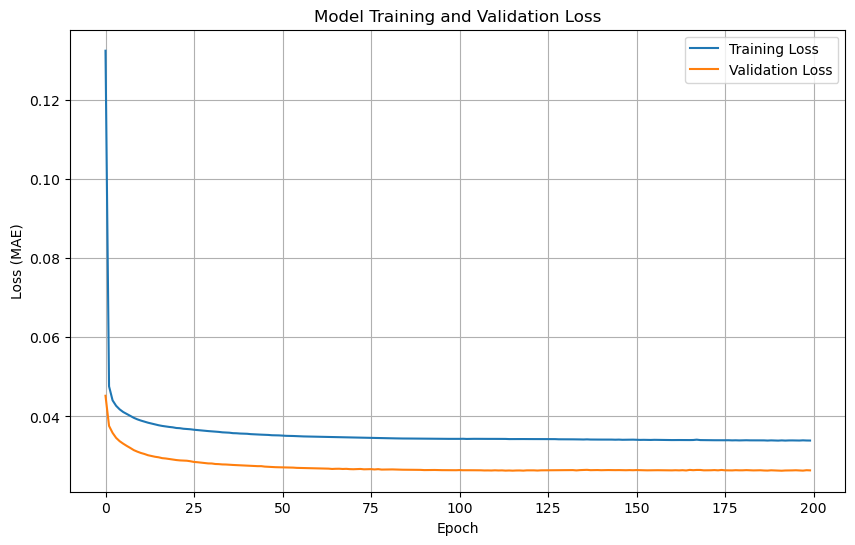

In [3]:
file_path = "Data_sst_2020/bay_of_bengal.nc"
dataset = mhw_mb.load_data(file_path)

# Data splitting 
(train_sst, train_month, train_time), (valid_sst, valid_month, valid_time), (test_sst, test_month, test_time) = mhw_mb.prepare_data_for_modeling(dataset)

# Scale and convert to supervised format
X_train, y_train, X_valid, y_valid, X_test, y_test, sst_min, sst_max = mhw_mb.scale_and_create_sequences(
    train_sst, train_month, valid_sst, valid_month, test_sst, test_month, n_lag, n_seq
)
print(X_train.shape)

model = mhw_mb.build_cnn_model(n_lag, n_features, n_seq, learning_rate=0.001)
model.summary()

# Fit Model
history = mhw_mb.fit_cnn_model(model, X_train, y_train, X_valid, y_valid, epochs=epochs, batch_size=batch_size)
mhw_mb.plot_training_history(history)


##### Model Testing and Evaluation

46/46 [==============================] - 0s 3ms/step


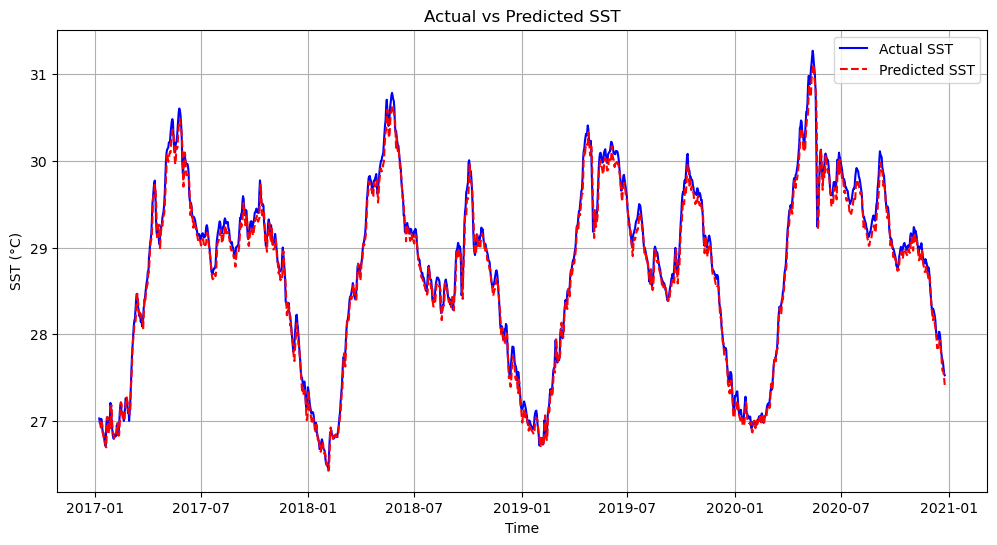

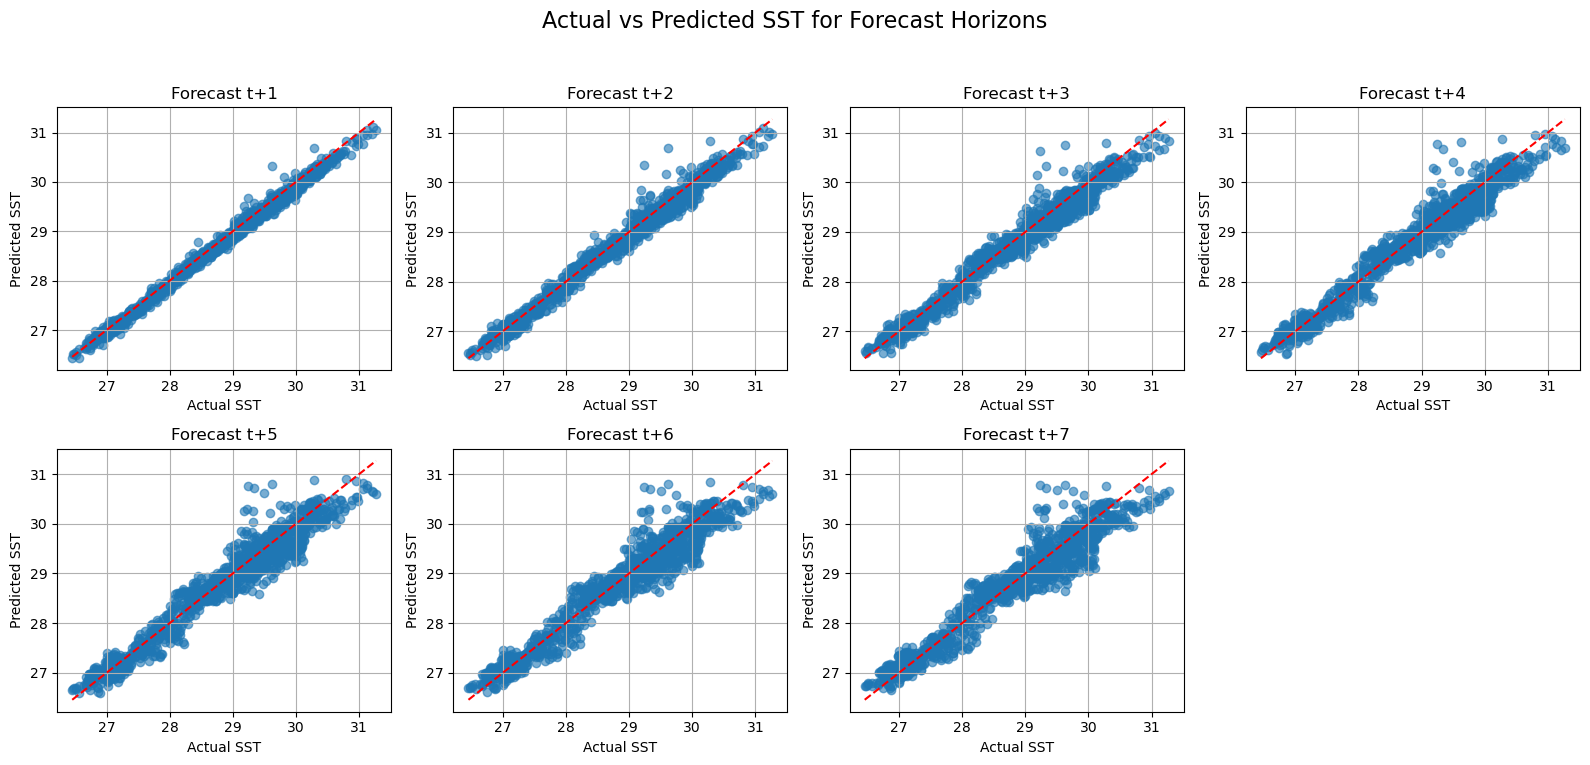

Forecast horizon t+1: RMSE = 0.1033, MAE = 0.0828, R2 = 0.9903
Forecast horizon t+2: RMSE = 0.1460, MAE = 0.1096, R2 = 0.9807
Forecast horizon t+3: RMSE = 0.1881, MAE = 0.1401, R2 = 0.9679
Forecast horizon t+4: RMSE = 0.2171, MAE = 0.1609, R2 = 0.9572
Forecast horizon t+5: RMSE = 0.2431, MAE = 0.1801, R2 = 0.9463
Forecast horizon t+6: RMSE = 0.2654, MAE = 0.1974, R2 = 0.9359
Forecast horizon t+7: RMSE = 0.2849, MAE = 0.2137, R2 = 0.9260


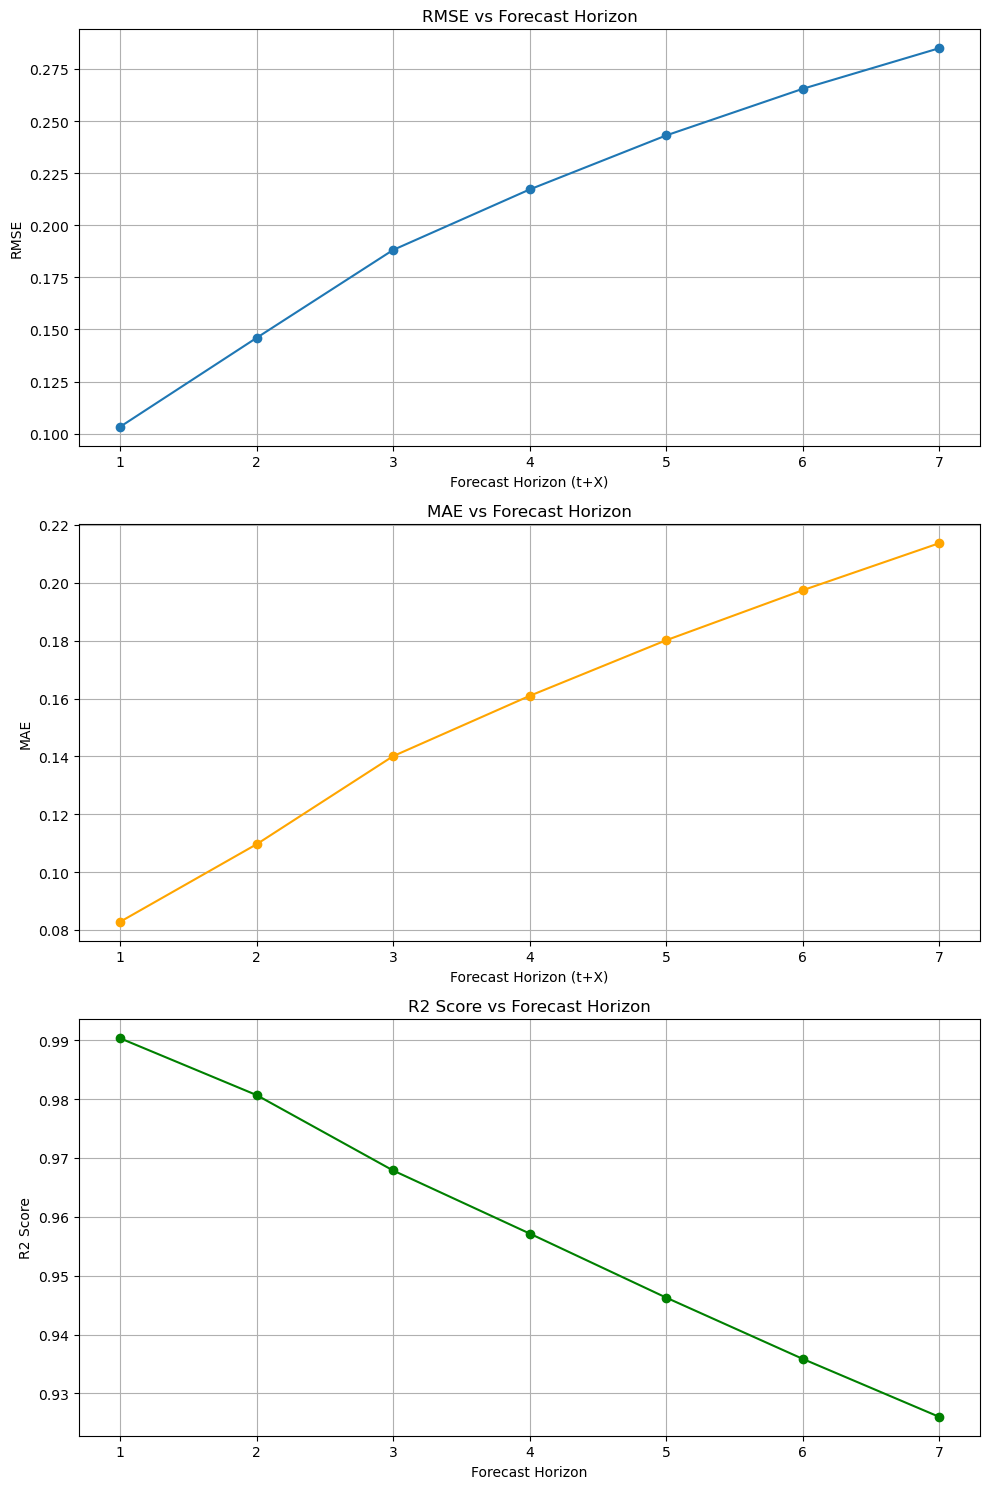

In [4]:
# Forecast and invert scaling
yhat_test_inverted, y_test_inverted = mhw_mb.forecast_and_invert(model, X_test, y_test, sst_min, sst_max)

# Extract predictions 
actual_t1_test = y_test_inverted[:, 0]
predicted_t1_test = yhat_test_inverted[:, 0]
adjusted_test_time = test_time[n_lag : - (n_seq - 1)]

mhw_mb.plot_actual_vs_predicted(
    adjusted_test_time, 
    actual_t1_test, 
    predicted_t1_test, 
    title="Actual vs Predicted SST"
)

mhw_mb.plot_sst_scatter_forecasts(y_test_inverted, yhat_test_inverted)

metrics_df_test = mhw_mb.plot_evaluation_metrics_all(y_test_inverted, yhat_test_inverted)
metrics_df_bay = metrics_df_test.copy()

#### MHW Prediciton Evaluation

In [5]:
# Load and prepare both datasets
train_ds_1, train_sst_1, train_t_1 = eda.load_and_prepare_data(file_path)
test_ds_1, test_sst_1, test_t_1 = eda.prepare_testing_dataset(file_path)


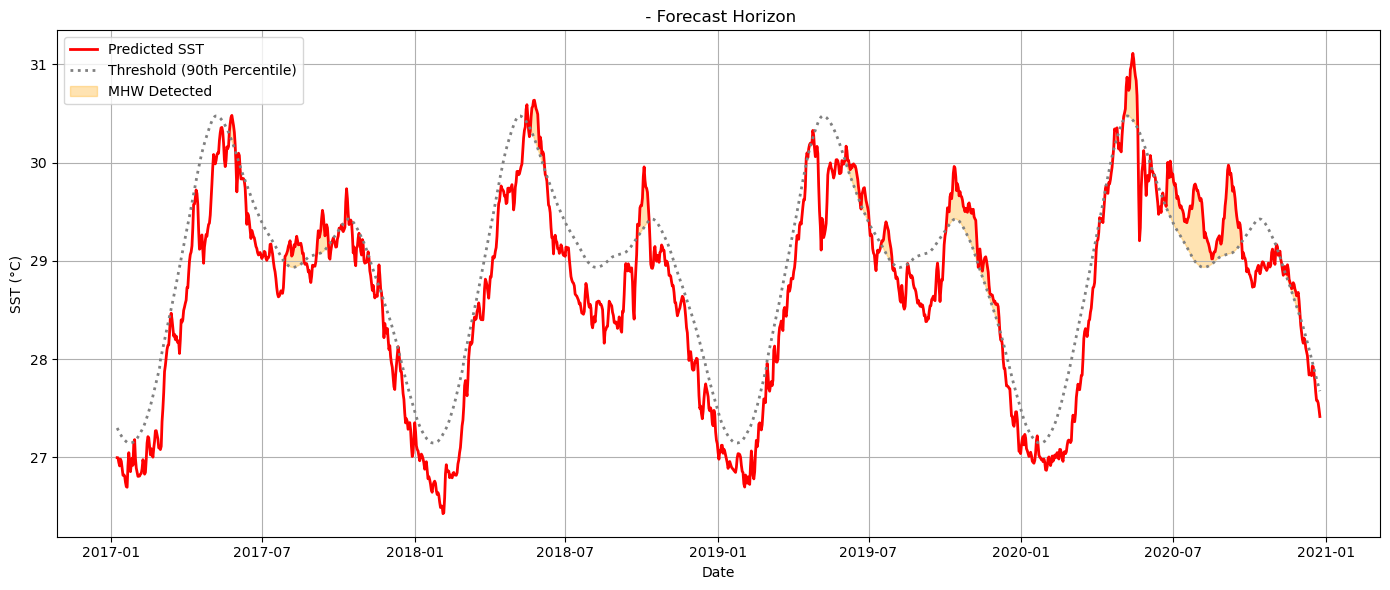

In [6]:
_, clim_pred = eda.detect_mhw_using_training_climatology(
    np.array([d.toordinal() for d in adjusted_test_time]),
    predicted_t1_test,
    train_t_1,
    train_sst_1
)

mhw_mb.plot_predicted_vs_climatology(
    time_array=adjusted_test_time,
    predicted_sst=predicted_t1_test,
    clim_ds=clim_pred)


Confusion Matrix for forecast horizon t+1:
[[1029    5]
 [  94  320]]


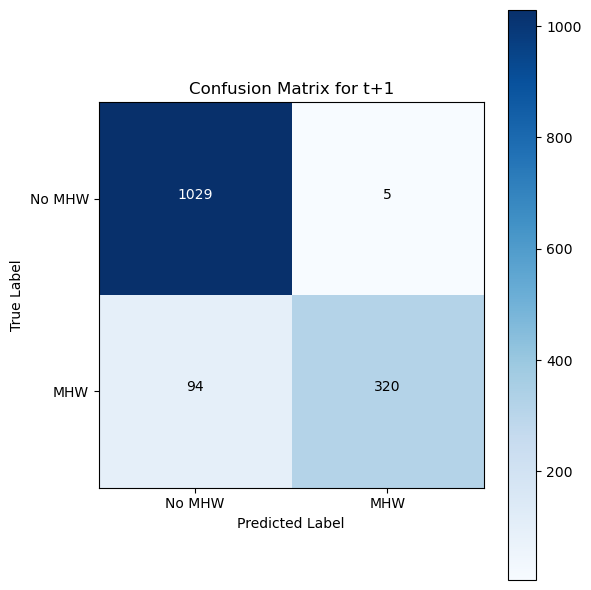

Confusion Matrix for forecast horizon t+2:
[[1018   16]
 [  95  319]]


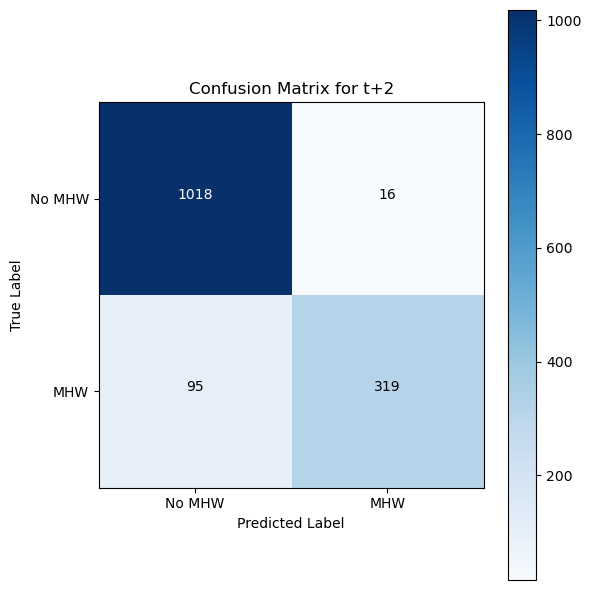

Confusion Matrix for forecast horizon t+3:
[[1012   22]
 [ 118  296]]


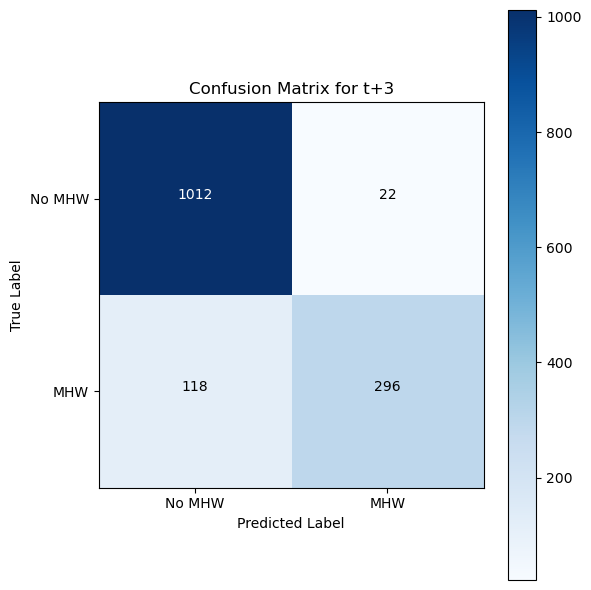

Confusion Matrix for forecast horizon t+4:
[[996  38]
 [110 304]]


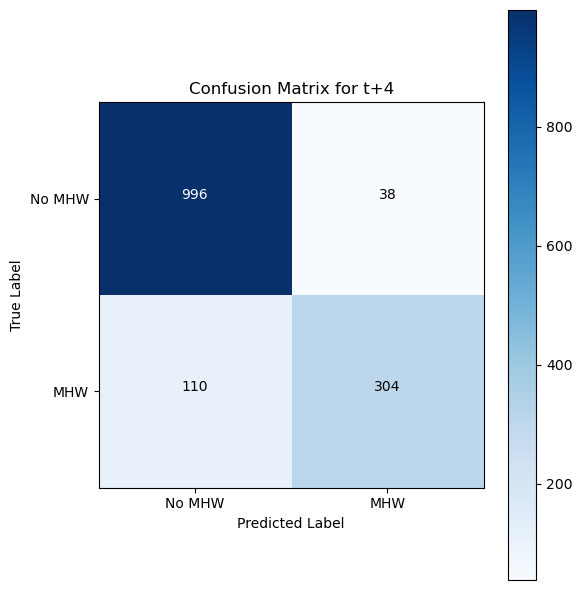

Confusion Matrix for forecast horizon t+5:
[[986  48]
 [125 289]]


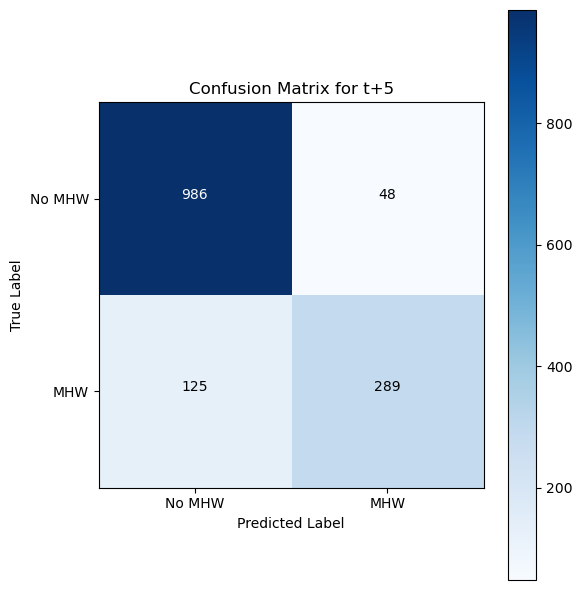

Confusion Matrix for forecast horizon t+6:
[[984  50]
 [148 266]]


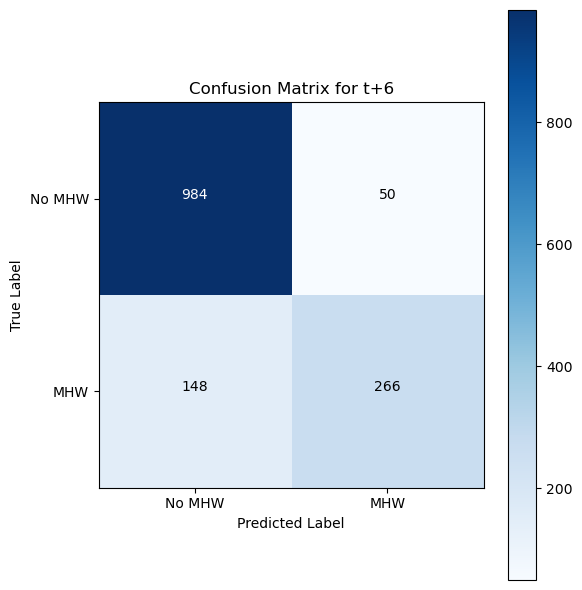

Confusion Matrix for forecast horizon t+7:
[[976  58]
 [174 240]]


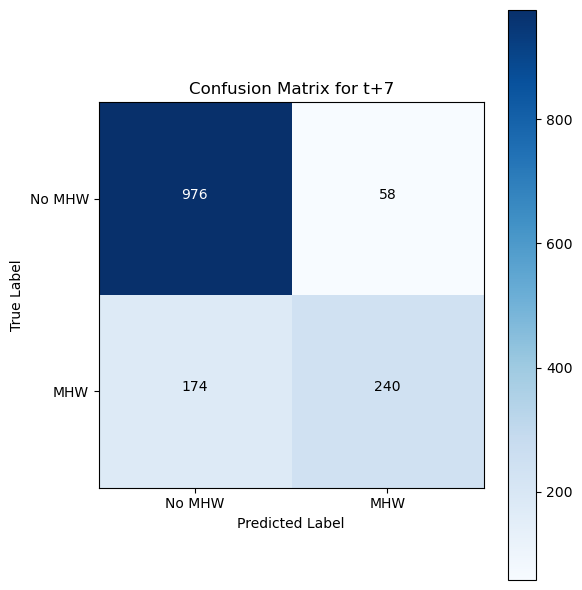

Precision  Recall (TPR)  F1 Score  Accuracy       FPR       TPR  \
Horizon                                                                    
t+1       0.984615      0.772947  0.866035  0.931630  0.004836  0.772947   
t+2       0.952239      0.770531  0.851802  0.923343  0.015474  0.770531   
t+3       0.930818      0.714976  0.808743  0.903315  0.021277  0.714976   
t+4       0.888889      0.734300  0.804233  0.897790  0.036750  0.734300   
t+5       0.857567      0.698068  0.769640  0.880525  0.046422  0.698068   
t+6       0.841772      0.642512  0.728767  0.863260  0.048356  0.642512   
t+7       0.805369      0.579710  0.674157  0.839779  0.056093  0.579710   

              FNR       FDR  
Horizon                      
t+1      0.227053  0.015385  
t+2      0.229469  0.047761  
t+3      0.285024  0.069182  
t+4      0.265700  0.111111  
t+5      0.301932  0.142433  
t+6      0.357488  0.158228  
t+7      0.420290  0.194631

In [7]:
# Evaluate metrics for each forecast horizon 
metrics_all = mhw_mb.evaluate_mhw_forecast_horizons(
    adjusted_test_time, y_test_inverted, yhat_test_inverted, train_t_1, train_sst_1, eda
)

df_metrics = mhw_mb.metrics_to_dataframe(metrics_all)
metrics_df_bay_mhw = df_metrics.copy()
df_metrics

### Gulf of Mannar

##### Model Training 

(10944, 7, 2)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 6, 64)             320       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 3, 64)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 192)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1351      
                                                                 
Total params: 1,671
Trainable params: 1,671
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
86/86 [==============================] - 2s 10ms/step - loss: 0.1503 - val_loss: 0.0585
Epoc

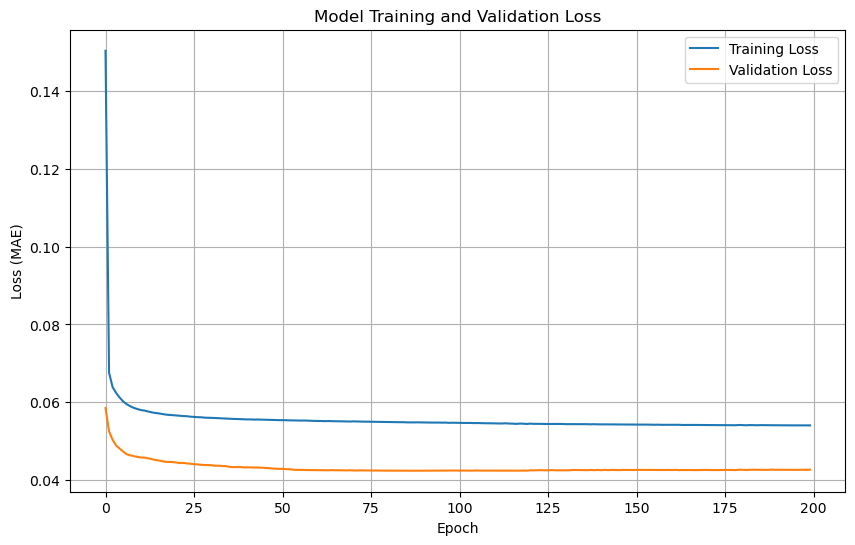

In [8]:
file_path = "Data_sst_2020/gulf_of_mannar.nc"
dataset = mhw_mb.load_data(file_path)

# Data splitting 
(train_sst, train_month, train_time), (valid_sst, valid_month, valid_time), (test_sst, test_month, test_time) = mhw_mb.prepare_data_for_modeling(dataset)

# Scale and convert to supervised format
X_train, y_train, X_valid, y_valid, X_test, y_test, sst_min, sst_max = mhw_mb.scale_and_create_sequences(
    train_sst, train_month, valid_sst, valid_month, test_sst, test_month, n_lag, n_seq
)
print(X_train.shape)

model = mhw_mb.build_cnn_model(n_lag, n_features, n_seq, learning_rate=0.001)
model.summary()

# Fit Model
history = mhw_mb.fit_cnn_model(model, X_train, y_train, X_valid, y_valid, epochs=epochs, batch_size=batch_size)
mhw_mb.plot_training_history(history)


##### Model Testing and Evaluation

46/46 [==============================] - 0s 3ms/step


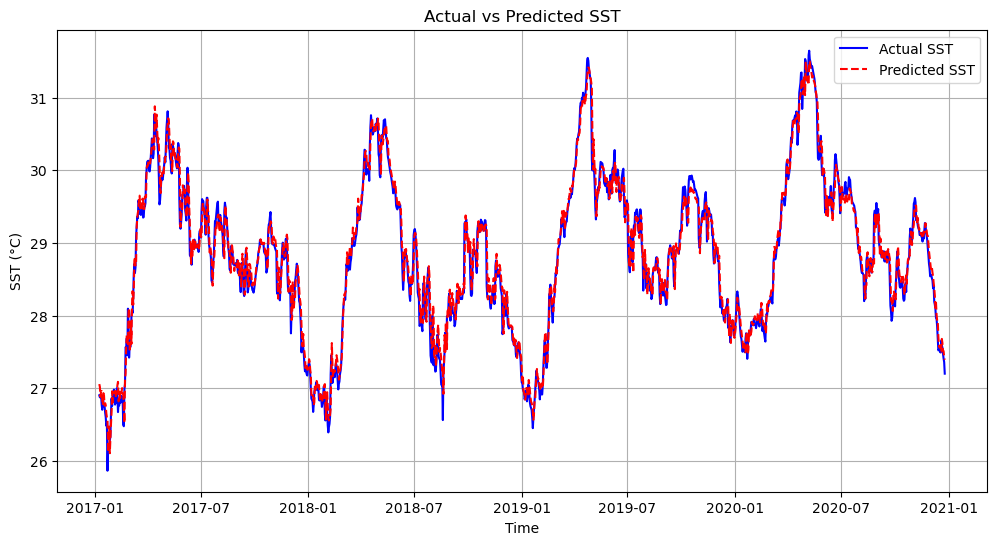

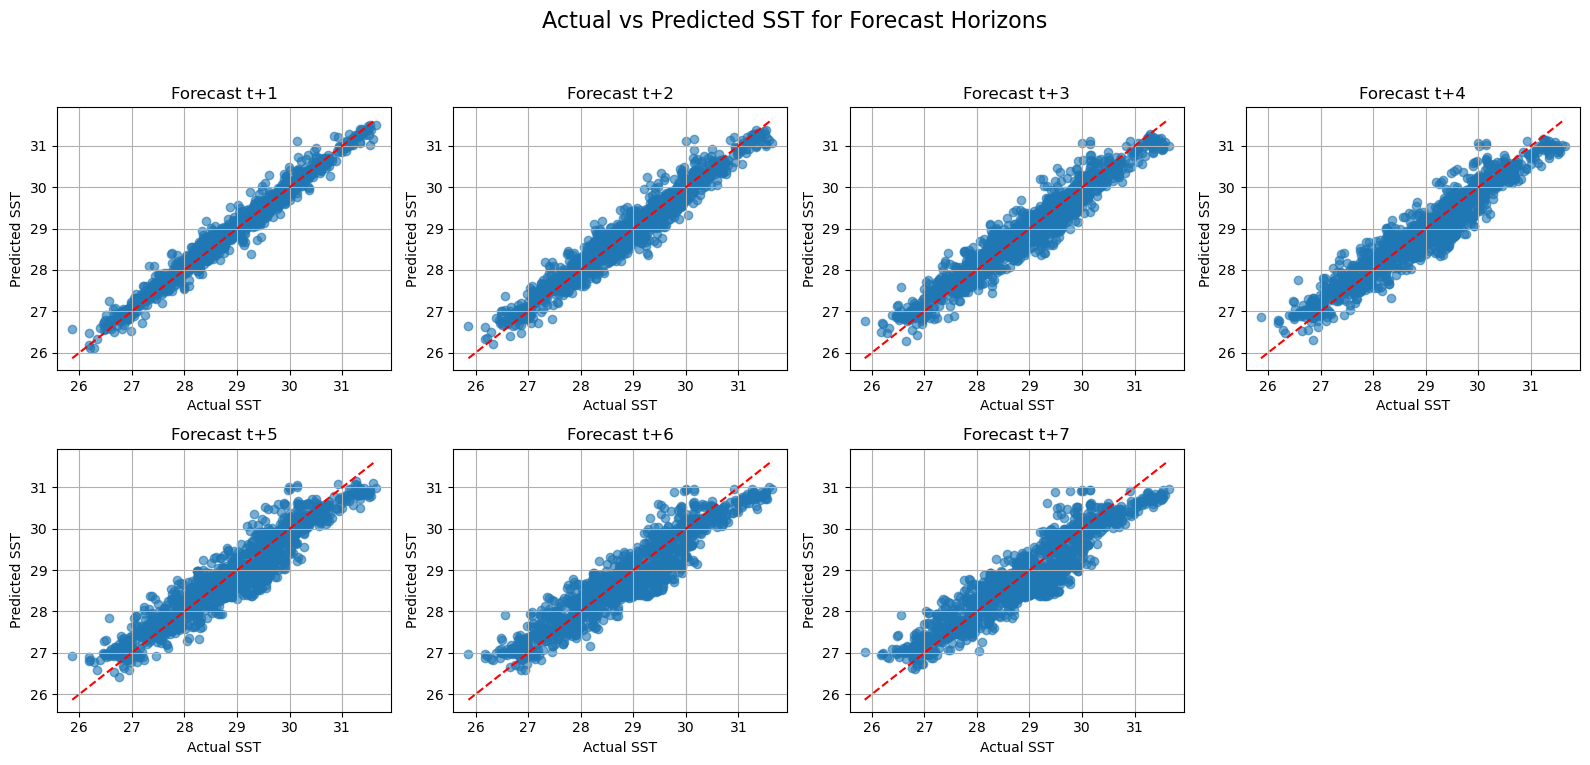

Forecast horizon t+1: RMSE = 0.1758, MAE = 0.1282, R2 = 0.9741
Forecast horizon t+2: RMSE = 0.2472, MAE = 0.1886, R2 = 0.9487
Forecast horizon t+3: RMSE = 0.2989, MAE = 0.2341, R2 = 0.9250
Forecast horizon t+4: RMSE = 0.3374, MAE = 0.2670, R2 = 0.9044
Forecast horizon t+5: RMSE = 0.3626, MAE = 0.2886, R2 = 0.8894
Forecast horizon t+6: RMSE = 0.3901, MAE = 0.3130, R2 = 0.8720
Forecast horizon t+7: RMSE = 0.4059, MAE = 0.3260, R2 = 0.8612


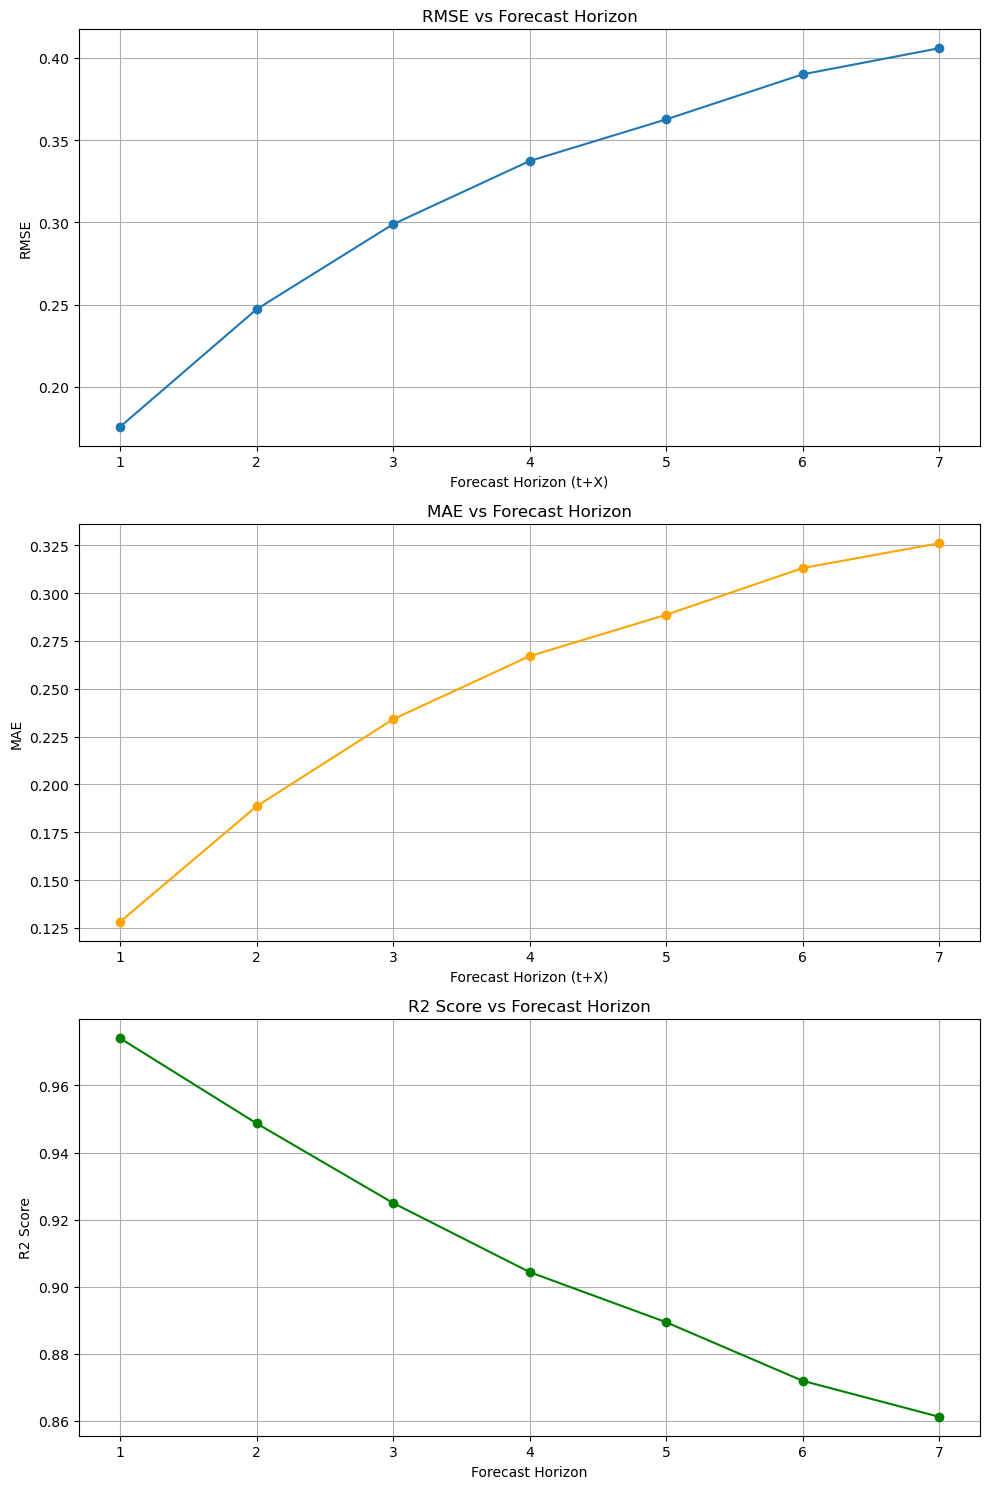

In [9]:
# Forecast and invert scaling
yhat_test_inverted, y_test_inverted = mhw_mb.forecast_and_invert(model, X_test, y_test, sst_min, sst_max)

actual_t1_test = y_test_inverted[:, 0]
predicted_t1_test = yhat_test_inverted[:, 0]

# Adjusting the test time array to align with the forecasts.
adjusted_test_time = test_time[n_lag : - (n_seq - 1)]

mhw_mb.plot_actual_vs_predicted(
    adjusted_test_time, 
    actual_t1_test, 
    predicted_t1_test, 
    title="Actual vs Predicted SST"
)

mhw_mb.plot_sst_scatter_forecasts(y_test_inverted, yhat_test_inverted)

metrics_df_test = mhw_mb.plot_evaluation_metrics_all(y_test_inverted, yhat_test_inverted)
metrics_df_mannar = metrics_df_test.copy()


#### MHW Prediciton Evaluation

In [10]:
train_ds_1, train_sst_1, train_t_1 = eda.load_and_prepare_data(file_path)
test_ds_1, test_sst_1, test_t_1 = eda.prepare_testing_dataset(file_path)


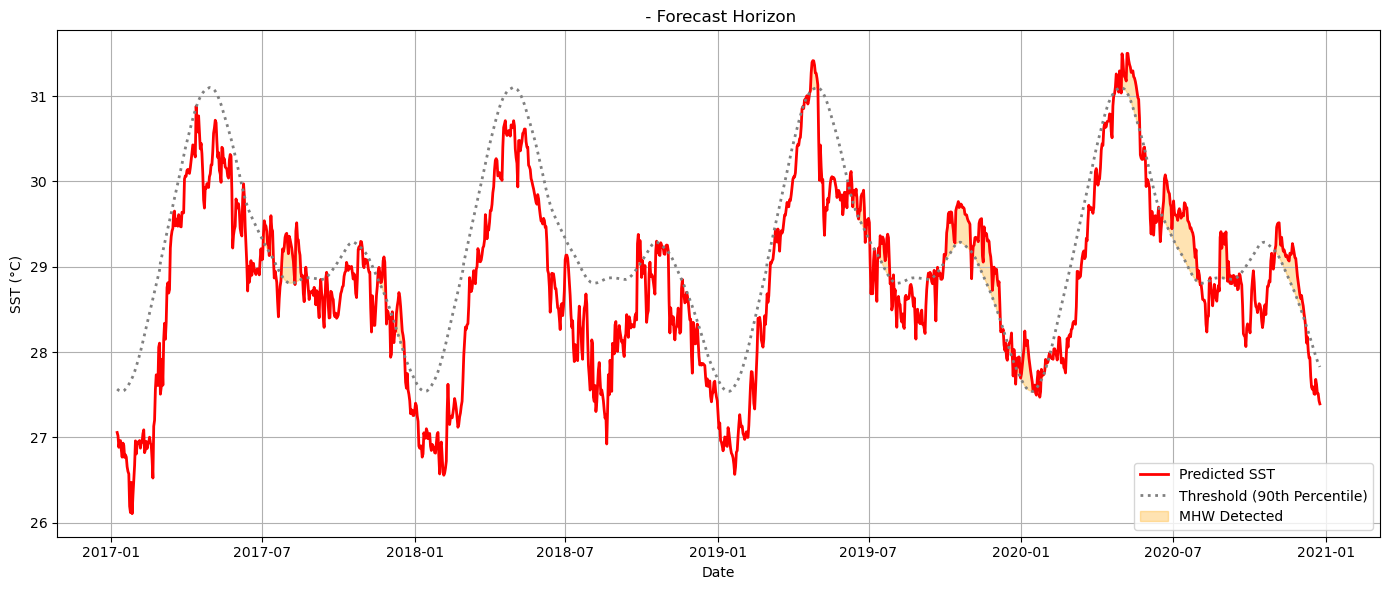

In [11]:
_, clim_pred = eda.detect_mhw_using_training_climatology(
    np.array([d.toordinal() for d in adjusted_test_time]),
    predicted_t1_test,
    train_t_1,
    train_sst_1
)

mhw_mb.plot_predicted_vs_climatology(
    time_array=adjusted_test_time,
    predicted_sst=predicted_t1_test,
    clim_ds=clim_pred
)


Confusion Matrix for forecast horizon t+1:
[[1074   46]
 [  60  268]]


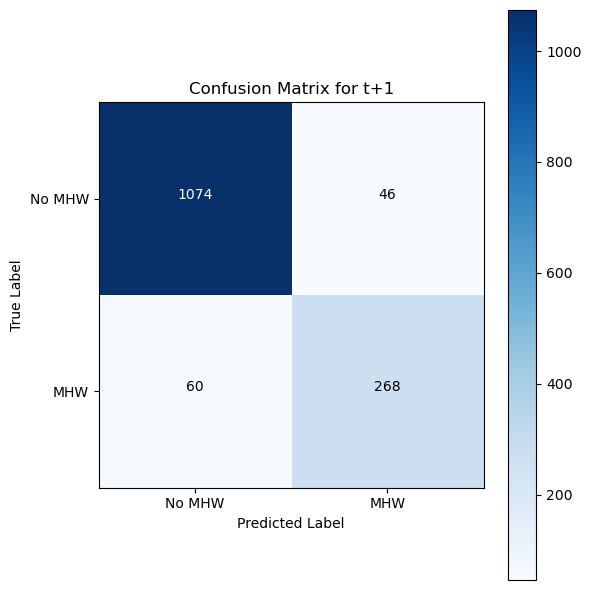

Confusion Matrix for forecast horizon t+2:
[[1074   46]
 [  85  243]]


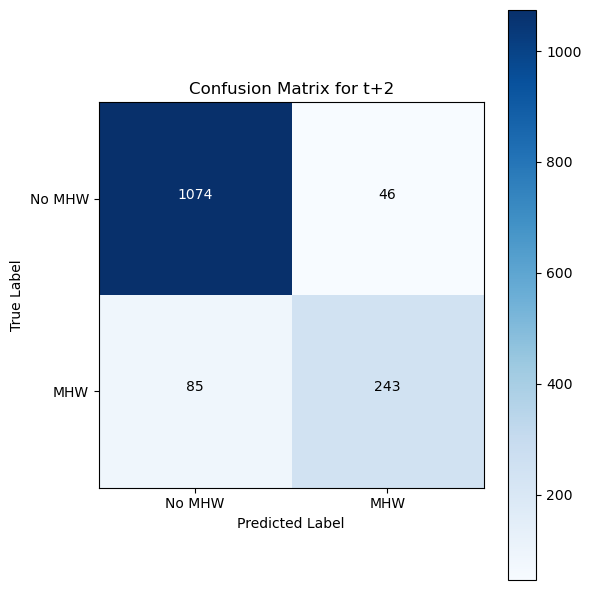

Confusion Matrix for forecast horizon t+3:
[[1075   45]
 [ 117  211]]


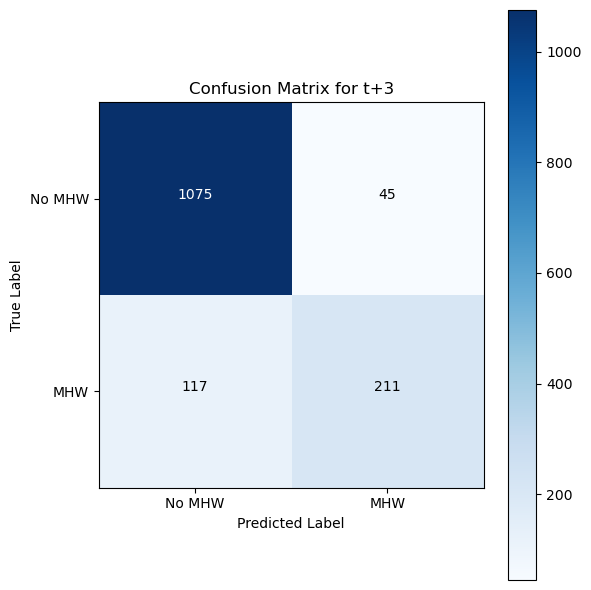

Confusion Matrix for forecast horizon t+4:
[[1071   49]
 [ 175  153]]


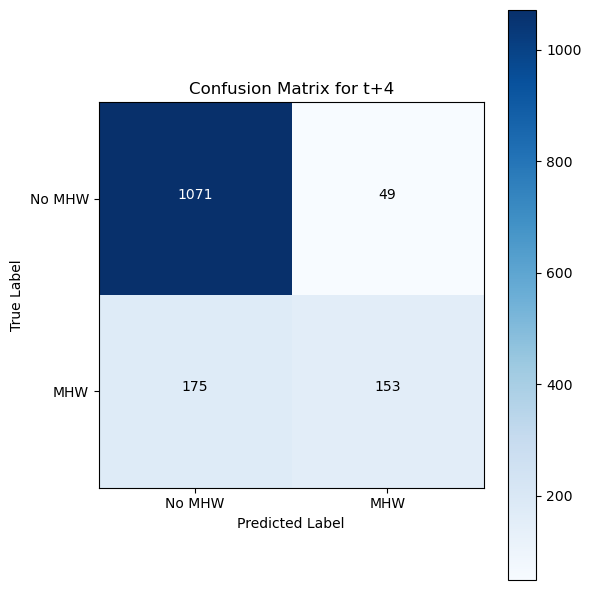

Confusion Matrix for forecast horizon t+5:
[[1071   49]
 [ 213  115]]


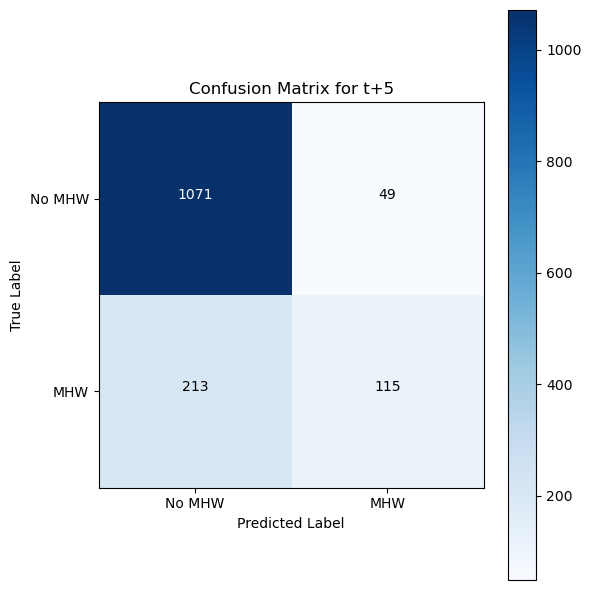

Confusion Matrix for forecast horizon t+6:
[[1068   52]
 [ 234   94]]


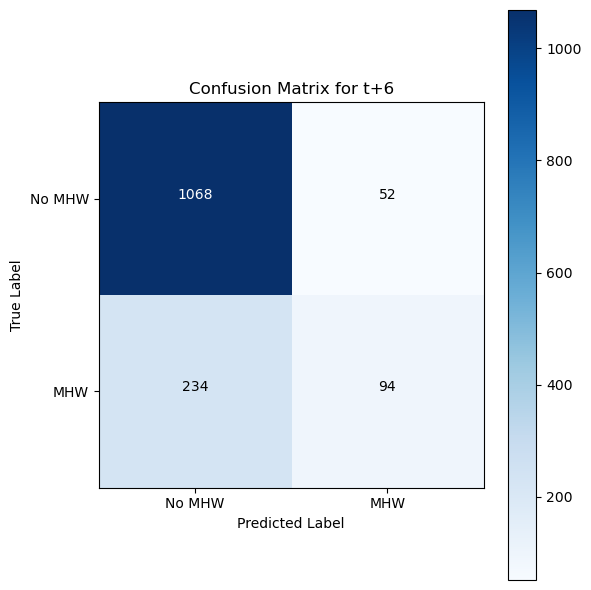

Confusion Matrix for forecast horizon t+7:
[[1066   54]
 [ 243   85]]


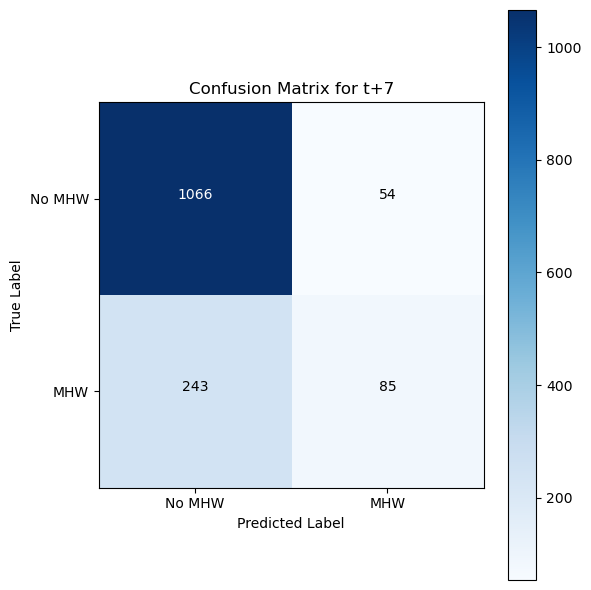

Precision  Recall (TPR)  F1 Score  Accuracy       FPR       TPR  \
Horizon                                                                    
t+1       0.853503      0.817073  0.834891  0.926796  0.041071  0.817073   
t+2       0.840830      0.740854  0.787682  0.909530  0.041071  0.740854   
t+3       0.824219      0.643293  0.722603  0.888122  0.040179  0.643293   
t+4       0.757426      0.466463  0.577358  0.845304  0.043750  0.466463   
t+5       0.701220      0.350610  0.467480  0.819061  0.043750  0.350610   
t+6       0.643836      0.286585  0.396624  0.802486  0.046429  0.286585   
t+7       0.611511      0.259146  0.364026  0.794890  0.048214  0.259146   

              FNR       FDR  
Horizon                      
t+1      0.182927  0.146497  
t+2      0.259146  0.159170  
t+3      0.356707  0.175781  
t+4      0.533537  0.242574  
t+5      0.649390  0.298780  
t+6      0.713415  0.356164  
t+7      0.740854  0.388489

In [12]:
# Evaluate metrics for each forecast horizon
metrics_all = mhw_mb.evaluate_mhw_forecast_horizons(
    adjusted_test_time, y_test_inverted, yhat_test_inverted, train_t_1, train_sst_1, eda
)

df_metrics = mhw_mb.metrics_to_dataframe(metrics_all)
metrics_df_mannar_mhw = df_metrics.copy()
df_metrics


### Laccadive Sea

##### Model Training 

(10944, 7, 2)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 6, 64)             320       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 3, 64)            0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 192)               0         
                                                                 
 dense_2 (Dense)             (None, 7)                 1351      
                                                                 
Total params: 1,671
Trainable params: 1,671
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
86/86 [==============================] - 2s 10ms/step - loss: 0.1223 - val_loss: 0.0482
Epoc

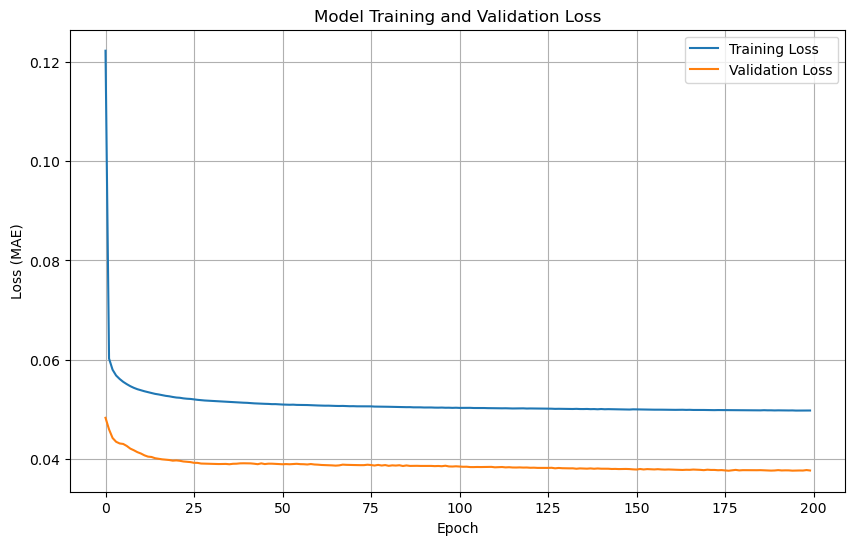

In [13]:
file_path = "Data_sst_2020/laccadive_sea.nc"
dataset = mhw_mb.load_data(file_path)

# Data splitting 
(train_sst, train_month, train_time), (valid_sst, valid_month, valid_time), (test_sst, test_month, test_time) = mhw_mb.prepare_data_for_modeling(dataset)

# Scale and convert to supervised format
X_train, y_train, X_valid, y_valid, X_test, y_test, sst_min, sst_max = mhw_mb.scale_and_create_sequences(
    train_sst, train_month, valid_sst, valid_month, test_sst, test_month, n_lag, n_seq
)
print(X_train.shape)

model = mhw_mb.build_cnn_model(n_lag, n_features, n_seq, learning_rate=0.001)
model.summary()

history = mhw_mb.fit_cnn_model(model, X_train, y_train, X_valid, y_valid, epochs=epochs, batch_size=batch_size)
mhw_mb.plot_training_history(history)


##### Model Testing and Evaluation

46/46 [==============================] - 0s 3ms/step


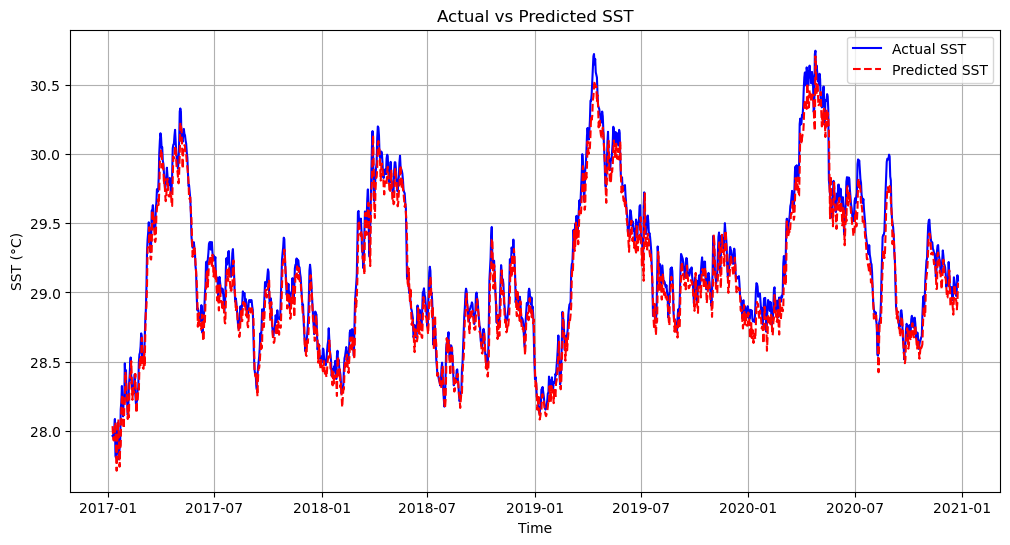

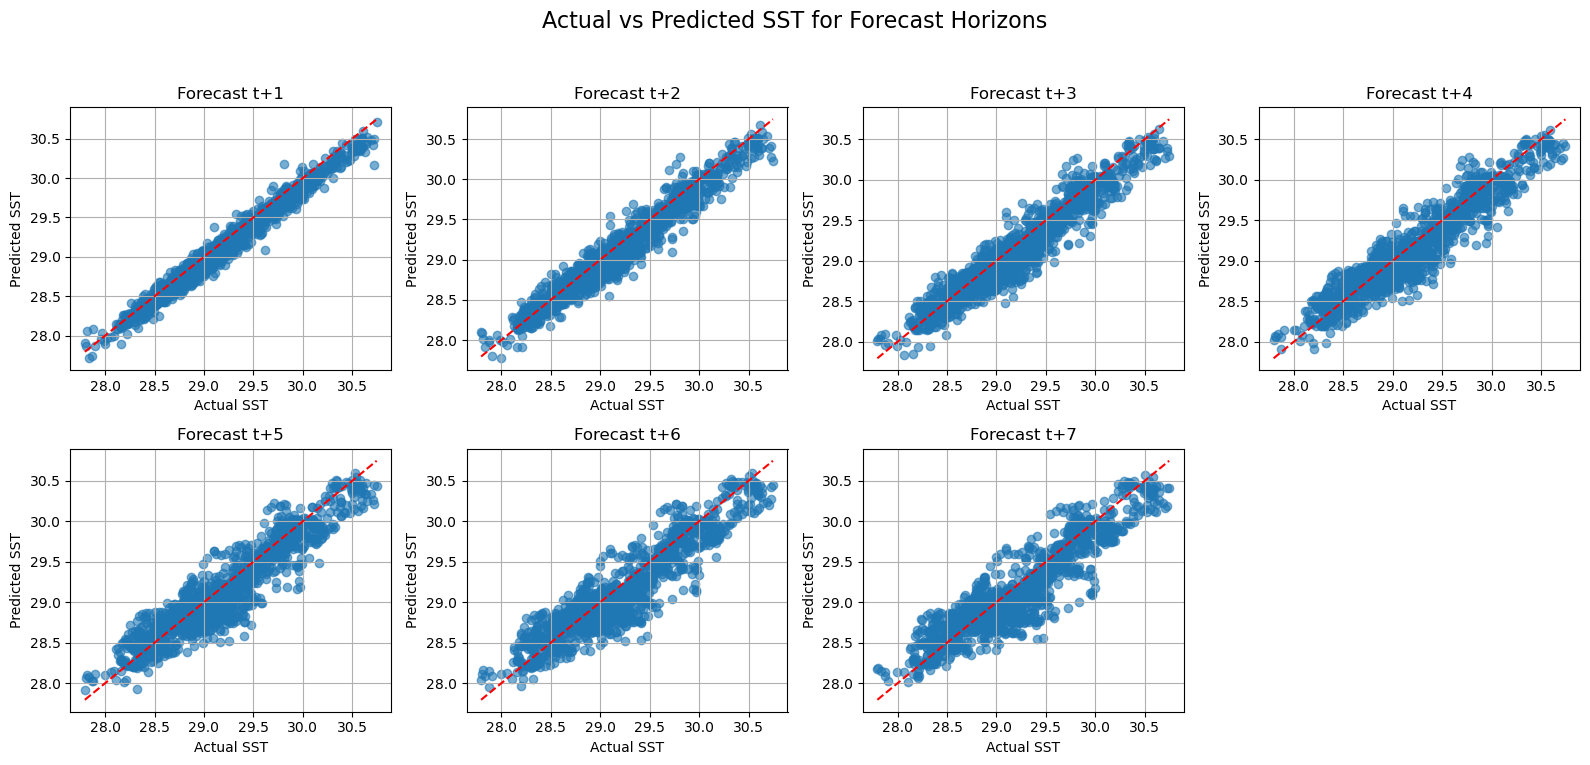

Forecast horizon t+1: RMSE = 0.1163, MAE = 0.0931, R2 = 0.9584
Forecast horizon t+2: RMSE = 0.1481, MAE = 0.1146, R2 = 0.9323
Forecast horizon t+3: RMSE = 0.1813, MAE = 0.1411, R2 = 0.8984
Forecast horizon t+4: RMSE = 0.1971, MAE = 0.1525, R2 = 0.8795
Forecast horizon t+5: RMSE = 0.2159, MAE = 0.1671, R2 = 0.8551
Forecast horizon t+6: RMSE = 0.2332, MAE = 0.1815, R2 = 0.8305
Forecast horizon t+7: RMSE = 0.2451, MAE = 0.1901, R2 = 0.8119


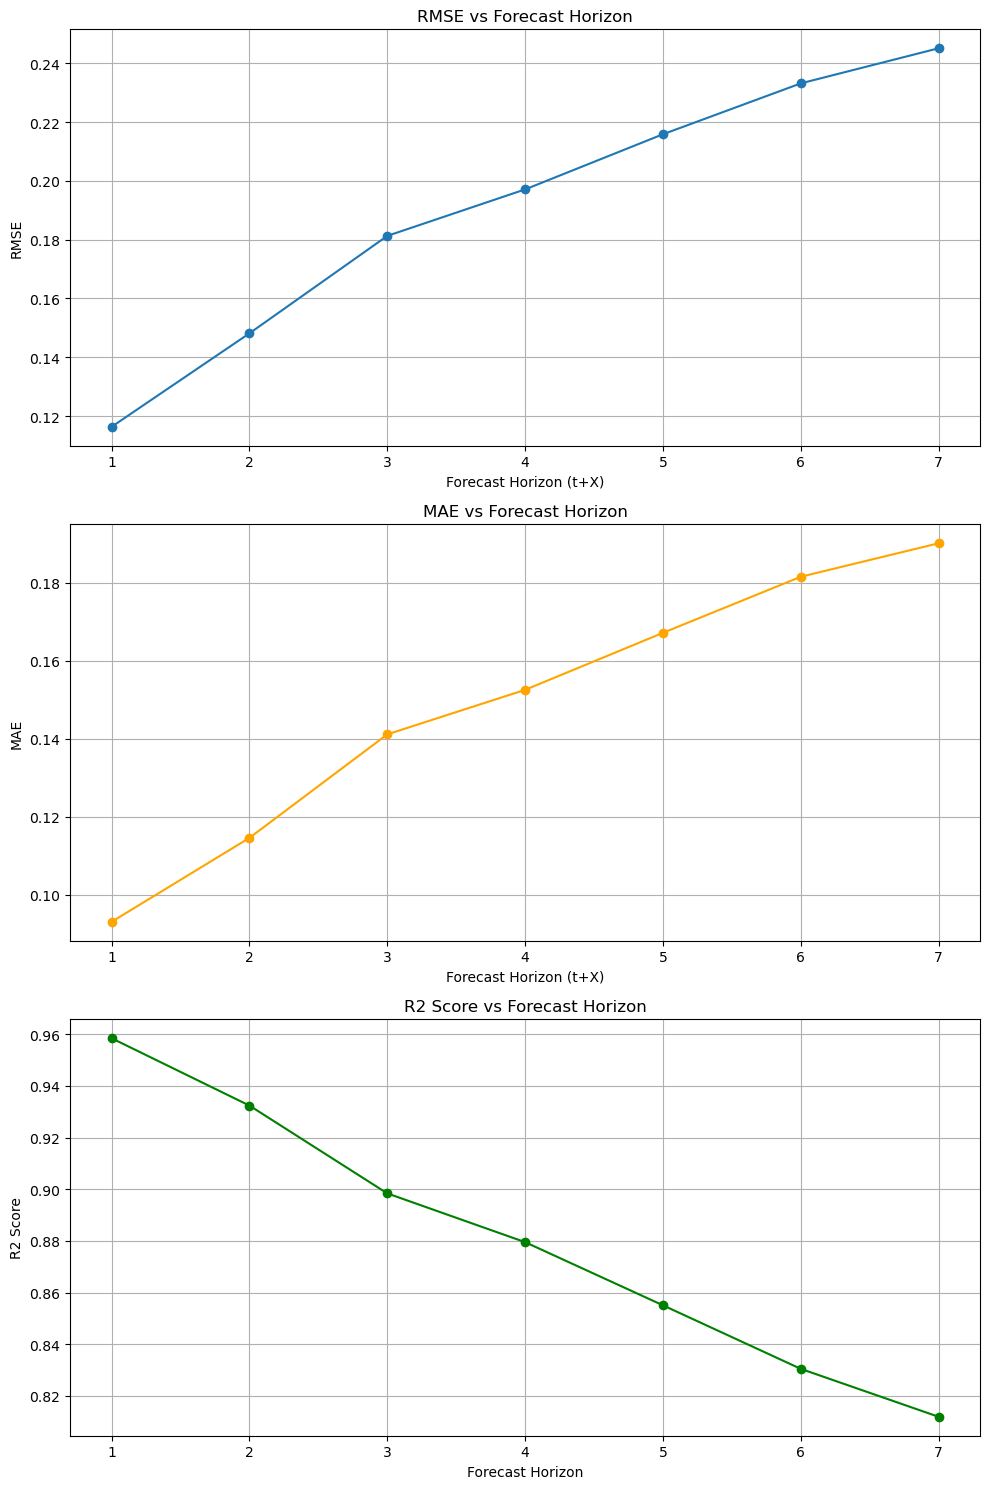

In [14]:
# Forecast and invert scaling
yhat_test_inverted, y_test_inverted = mhw_mb.forecast_and_invert(model, X_test, y_test, sst_min, sst_max)

# Extract predictions 
actual_t1_test = y_test_inverted[:, 0]
predicted_t1_test = yhat_test_inverted[:, 0]
adjusted_test_time = test_time[n_lag : - (n_seq - 1)]

mhw_mb.plot_actual_vs_predicted(
    adjusted_test_time, 
    actual_t1_test, 
    predicted_t1_test, 
    title="Actual vs Predicted SST"
)

mhw_mb.plot_sst_scatter_forecasts(y_test_inverted, yhat_test_inverted)

metrics_df_test = mhw_mb.plot_evaluation_metrics_all(y_test_inverted, yhat_test_inverted)
metrics_df_laccadive = metrics_df_test.copy()


#### MHW Prediciton Evaluation

In [15]:
train_ds_1, train_sst_1, train_t_1 = eda.load_and_prepare_data(file_path)
test_ds_1, test_sst_1, test_t_1 = eda.prepare_testing_dataset(file_path)


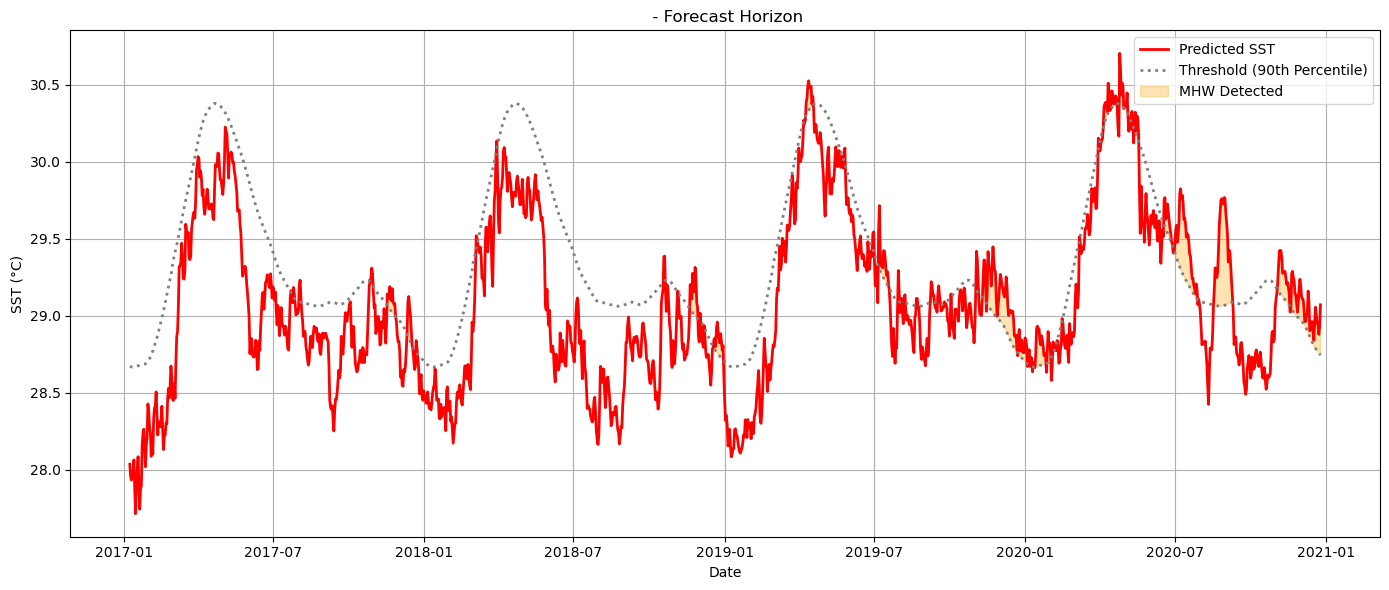

In [16]:
_, clim_pred = eda.detect_mhw_using_training_climatology(
    np.array([d.toordinal() for d in adjusted_test_time]),
    predicted_t1_test,
    train_t_1,
    train_sst_1
)

mhw_mb.plot_predicted_vs_climatology(
    time_array=adjusted_test_time,
    predicted_sst=predicted_t1_test,
    clim_ds=clim_pred
)


Confusion Matrix for forecast horizon t+1:
[[1042    4]
 [ 127  275]]


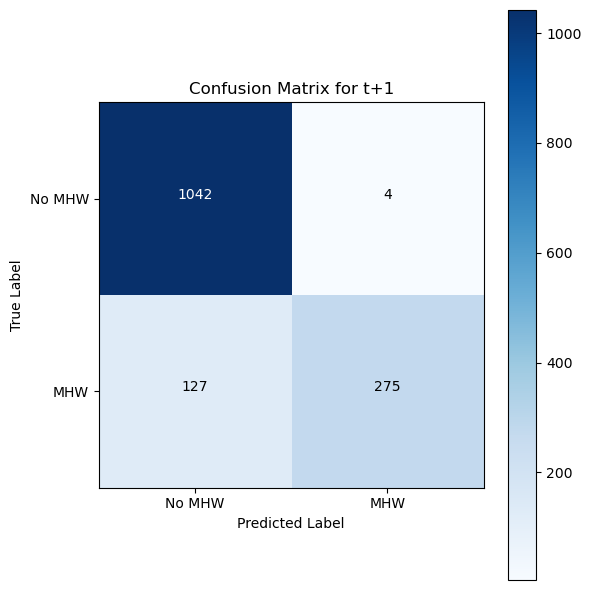

Confusion Matrix for forecast horizon t+2:
[[1031   14]
 [ 121  282]]


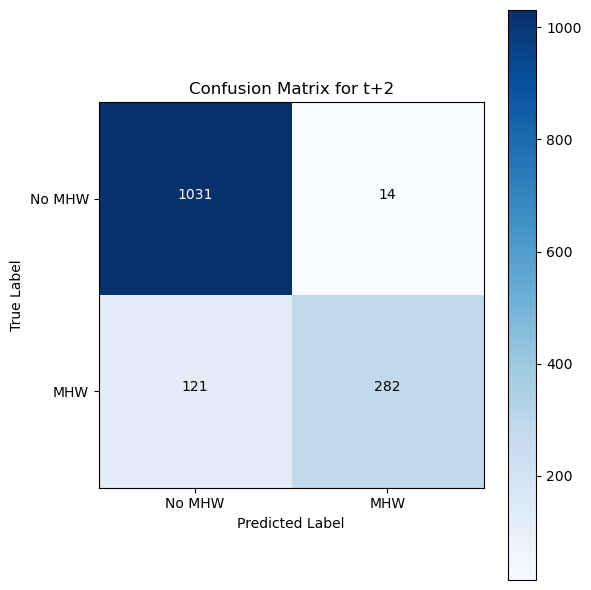

Confusion Matrix for forecast horizon t+3:
[[1021   23]
 [ 143  261]]


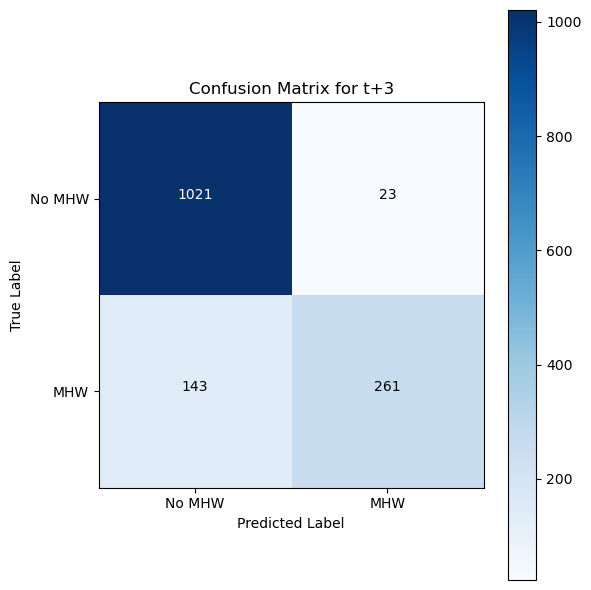

Confusion Matrix for forecast horizon t+4:
[[1010   33]
 [ 146  259]]


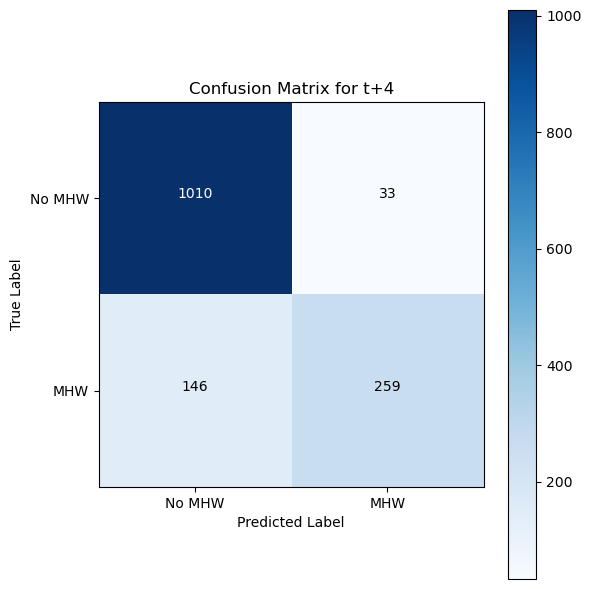

Confusion Matrix for forecast horizon t+5:
[[999  43]
 [158 248]]


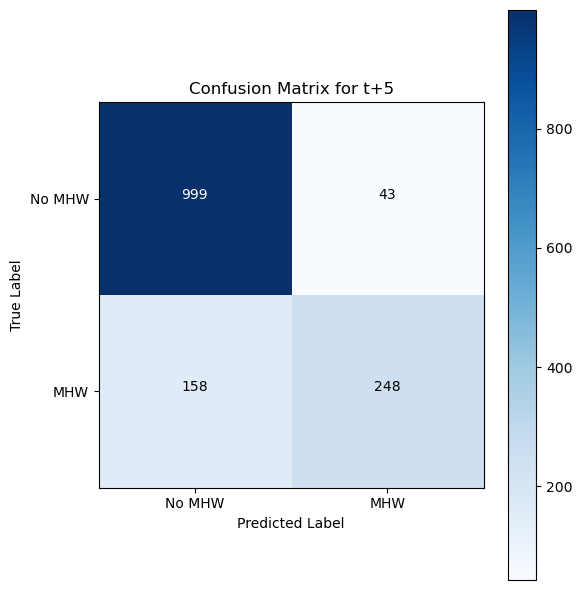

Confusion Matrix for forecast horizon t+6:
[[998  43]
 [191 216]]


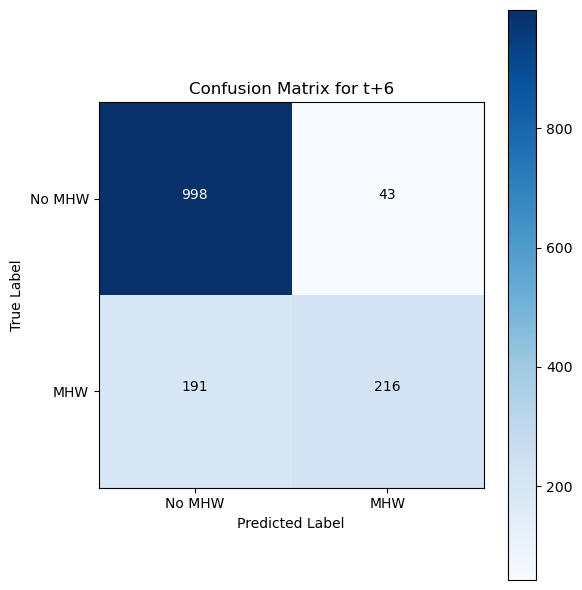

Confusion Matrix for forecast horizon t+7:
[[990  50]
 [208 200]]


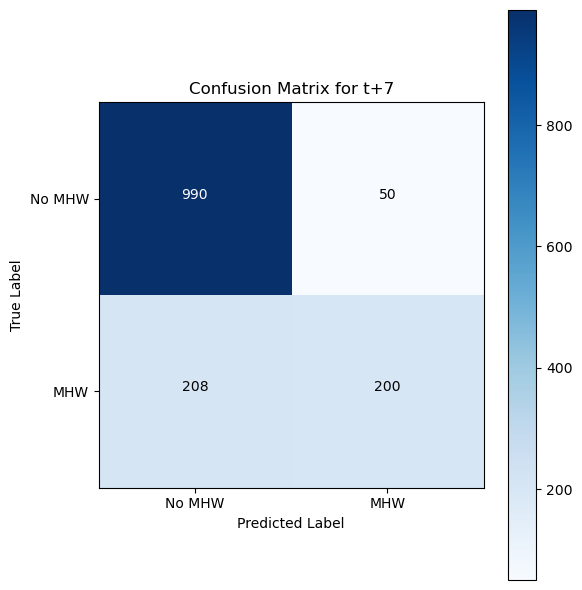

Precision  Recall (TPR)  F1 Score  Accuracy       FPR       TPR  \
Horizon                                                                    
t+1       0.985663      0.684080  0.807636  0.909530  0.003824  0.684080   
t+2       0.952703      0.699752  0.806867  0.906768  0.013397  0.699752   
t+3       0.919014      0.646040  0.758721  0.885359  0.022031  0.646040   
t+4       0.886986      0.639506  0.743185  0.876381  0.031640  0.639506   
t+5       0.852234      0.610837  0.711621  0.861188  0.041267  0.610837   
t+6       0.833977      0.530713  0.648649  0.838398  0.041306  0.530713   
t+7       0.800000      0.490196  0.607903  0.821823  0.048077  0.490196   

              FNR       FDR  
Horizon                      
t+1      0.315920  0.014337  
t+2      0.300248  0.047297  
t+3      0.353960  0.080986  
t+4      0.360494  0.113014  
t+5      0.389163  0.147766  
t+6      0.469287  0.166023  
t+7      0.509804  0.200000

In [17]:
metrics_all = mhw_mb.evaluate_mhw_forecast_horizons(
    adjusted_test_time, y_test_inverted, yhat_test_inverted, train_t_1, train_sst_1, eda
)

df_metrics = mhw_mb.metrics_to_dataframe(metrics_all)
metrics_df_laccadive_mhw = df_metrics.copy()
df_metrics


### Sri Lankan Coast

##### Model Training 

(10944, 7, 2)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 6, 64)             320       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 3, 64)            0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 192)               0         
                                                                 
 dense_3 (Dense)             (None, 7)                 1351      
                                                                 
Total params: 1,671
Trainable params: 1,671
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
86/86 [==============================] - 2s 10ms/step - loss: 0.1579 - val_loss: 0.0529
Epoc

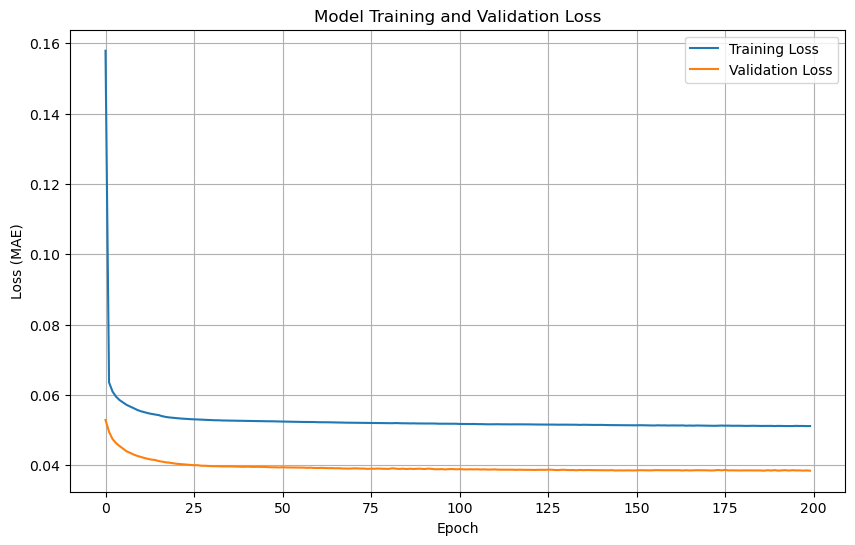

In [18]:
file_path = "Data_sst_2020/sri_lankan_coast.nc"
dataset = mhw_mb.load_data(file_path)

# Data splitting 
(train_sst, train_month, train_time), (valid_sst, valid_month, valid_time), (test_sst, test_month, test_time) = mhw_mb.prepare_data_for_modeling(dataset)

# Scale and convert to supervised format
X_train, y_train, X_valid, y_valid, X_test, y_test, sst_min, sst_max = mhw_mb.scale_and_create_sequences(
    train_sst, train_month, valid_sst, valid_month, test_sst, test_month, n_lag, n_seq
)
print(X_train.shape)

model = mhw_mb.build_cnn_model(n_lag, n_features, n_seq, learning_rate=0.001)
model.summary()

# Fit Model
history = mhw_mb.fit_cnn_model(model, X_train, y_train, X_valid, y_valid, epochs=epochs, batch_size=batch_size)
mhw_mb.plot_training_history(history)


##### Model Testing and Evaluation

46/46 [==============================] - 0s 3ms/step


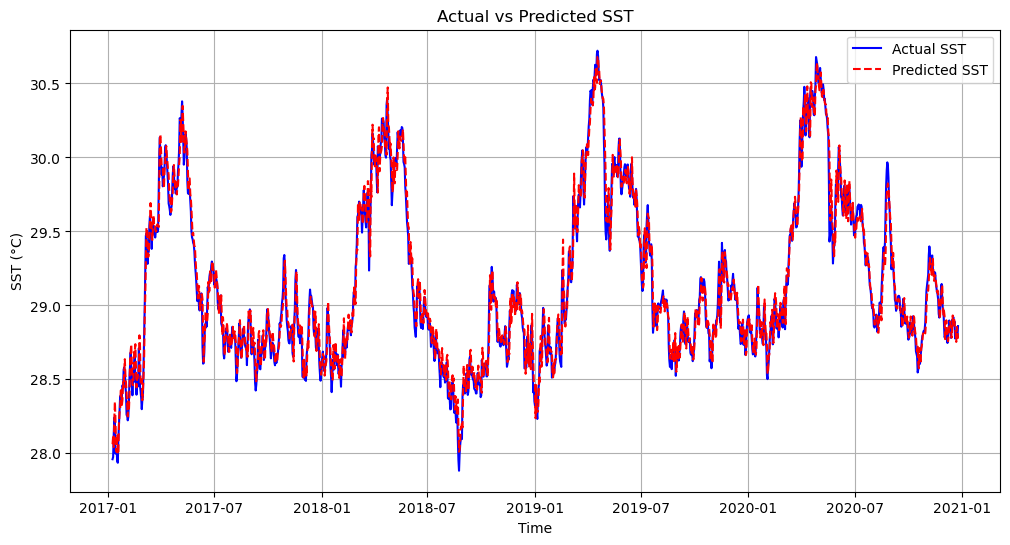

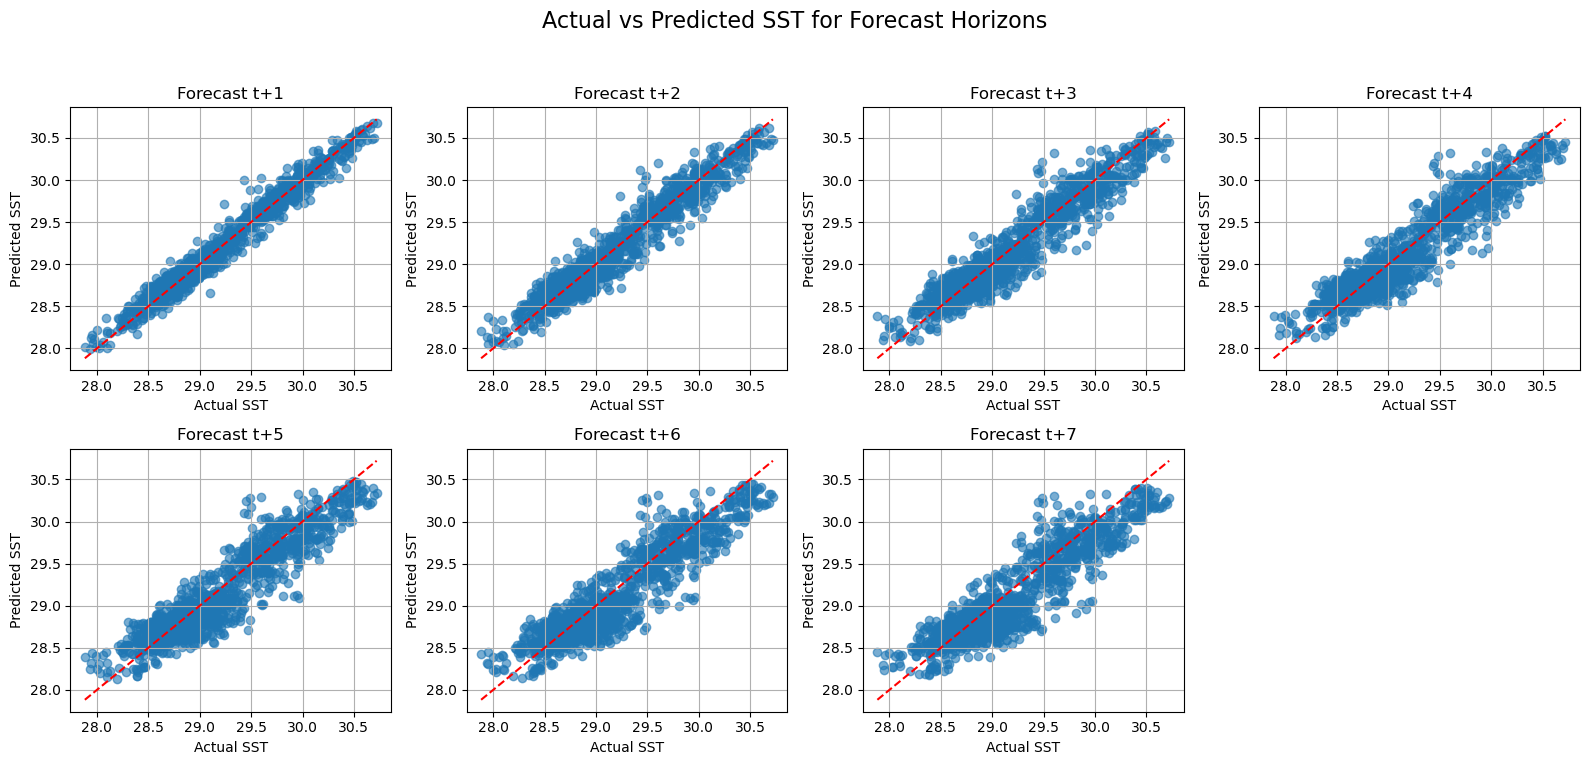

Forecast horizon t+1: RMSE = 0.0971, MAE = 0.0741, R2 = 0.9707
Forecast horizon t+2: RMSE = 0.1433, MAE = 0.1096, R2 = 0.9360
Forecast horizon t+3: RMSE = 0.1733, MAE = 0.1336, R2 = 0.9062
Forecast horizon t+4: RMSE = 0.1910, MAE = 0.1466, R2 = 0.8858
Forecast horizon t+5: RMSE = 0.2084, MAE = 0.1602, R2 = 0.8639
Forecast horizon t+6: RMSE = 0.2247, MAE = 0.1736, R2 = 0.8414
Forecast horizon t+7: RMSE = 0.2404, MAE = 0.1858, R2 = 0.8179


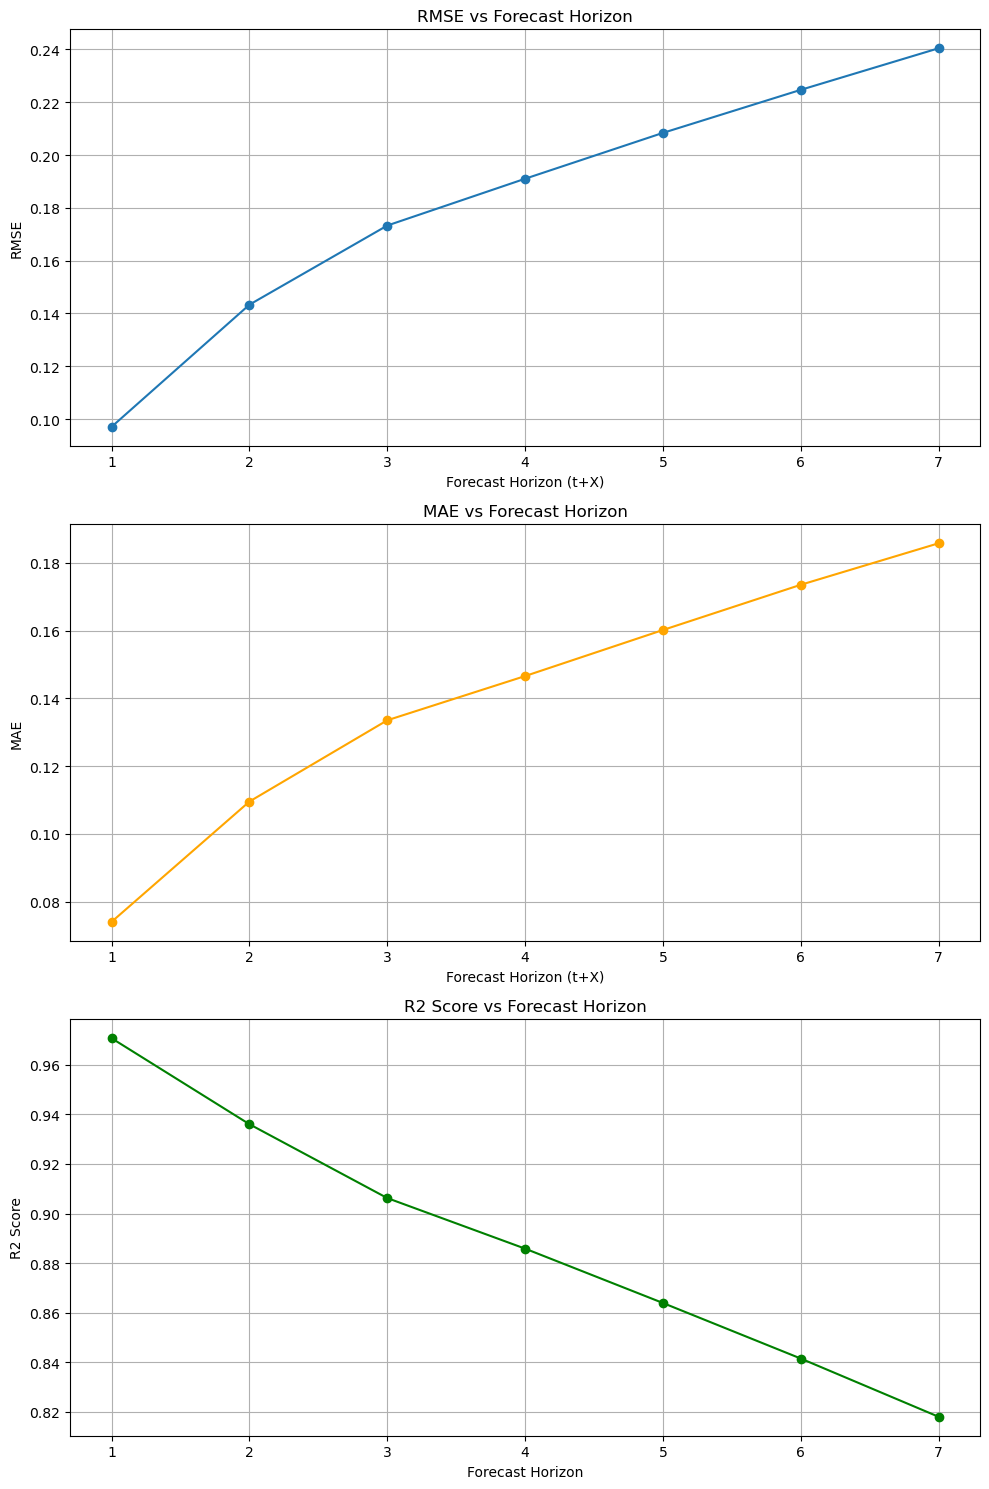

In [19]:
# Forecast and invert scaling
yhat_test_inverted, y_test_inverted = mhw_mb.forecast_and_invert(model, X_test, y_test, sst_min, sst_max)

# Extract predictions 
actual_t1_test = y_test_inverted[:, 0]
predicted_t1_test = yhat_test_inverted[:, 0]
adjusted_test_time = test_time[n_lag : - (n_seq - 1)]

mhw_mb.plot_actual_vs_predicted(
    adjusted_test_time, 
    actual_t1_test, 
    predicted_t1_test, 
    title="Actual vs Predicted SST"
)

mhw_mb.plot_sst_scatter_forecasts(y_test_inverted, yhat_test_inverted)
metrics_df_test = mhw_mb.plot_evaluation_metrics_all(y_test_inverted, yhat_test_inverted)
metrics_df_sl = metrics_df_test.copy()


#### MHW Prediciton Evaluation

In [20]:
train_ds_1, train_sst_1, train_t_1 = eda.load_and_prepare_data(file_path)
test_ds_1, test_sst_1, test_t_1 = eda.prepare_testing_dataset(file_path)


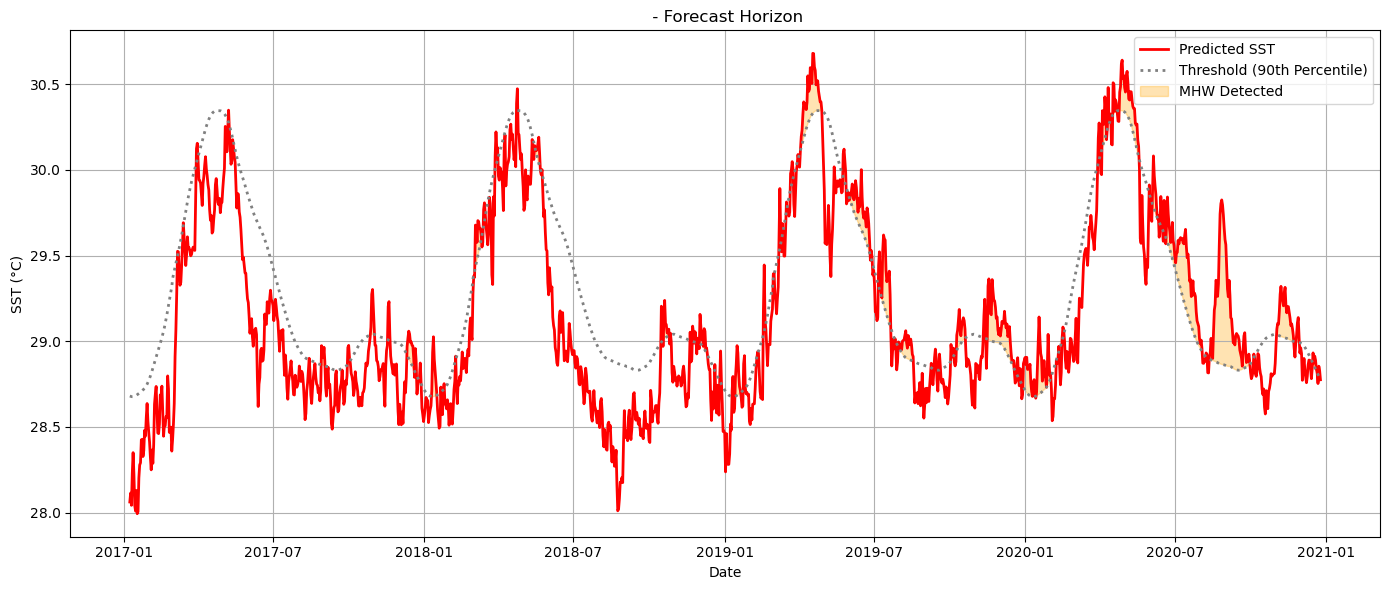

In [21]:
_, clim_pred = eda.detect_mhw_using_training_climatology(
    np.array([d.toordinal() for d in adjusted_test_time]),
    predicted_t1_test,
    train_t_1,
    train_sst_1
)

mhw_mb.plot_predicted_vs_climatology(
    time_array=adjusted_test_time,
    predicted_sst=predicted_t1_test,
    clim_ds=clim_pred)

Confusion Matrix for forecast horizon t+1:
[[1004   35]
 [  48  361]]


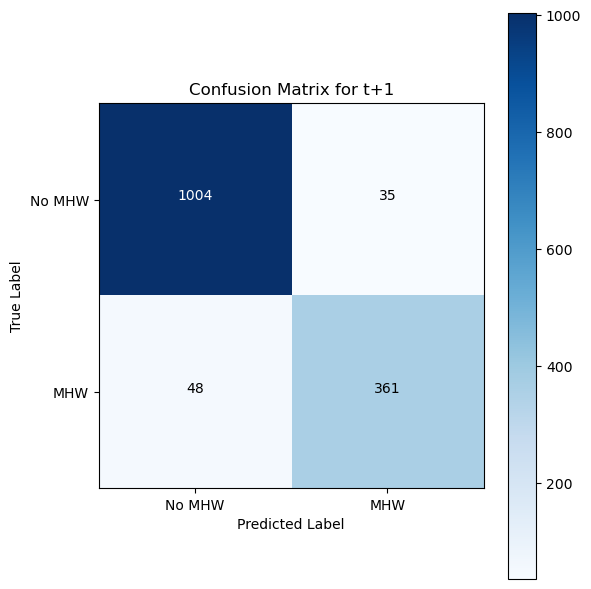

Confusion Matrix for forecast horizon t+2:
[[992  47]
 [110 299]]


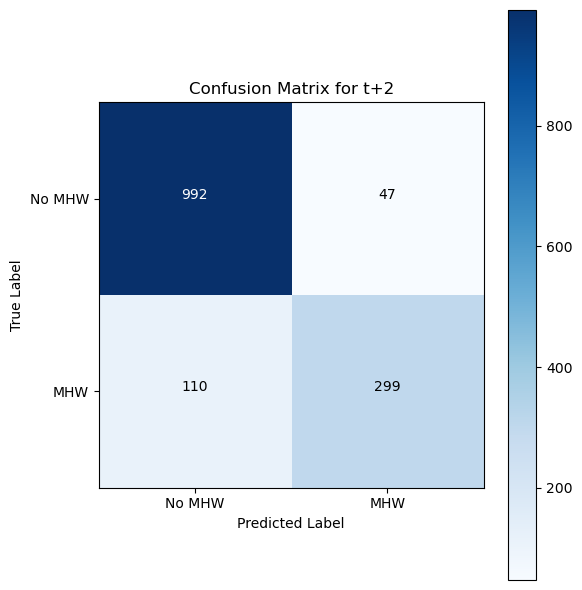

Confusion Matrix for forecast horizon t+3:
[[987  52]
 [162 247]]


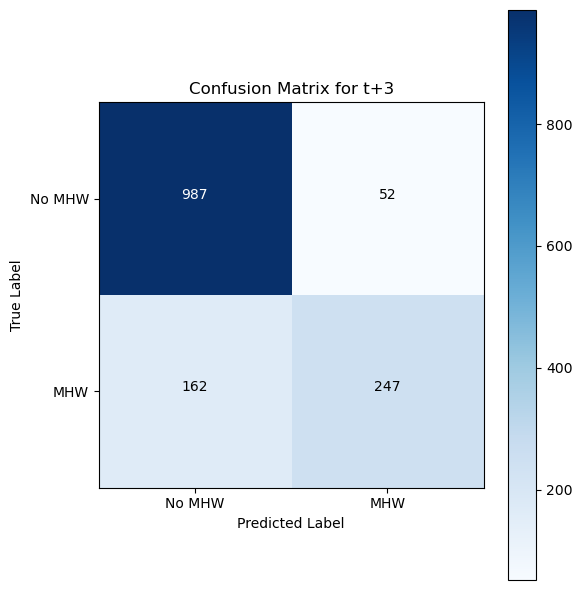

Confusion Matrix for forecast horizon t+4:
[[992  47]
 [199 210]]


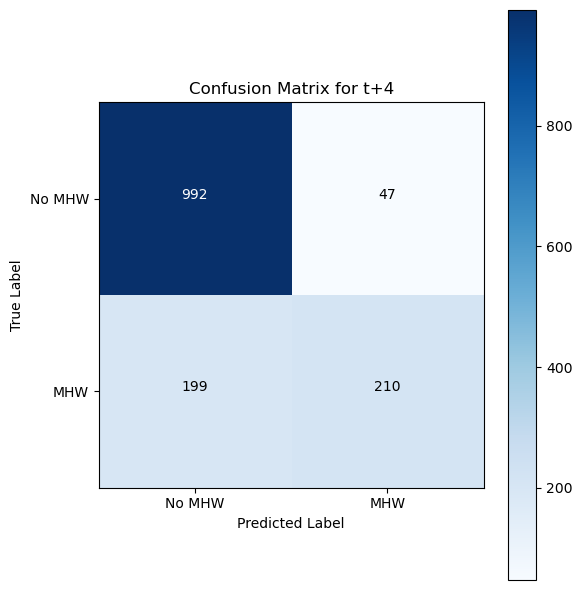

Confusion Matrix for forecast horizon t+5:
[[987  47]
 [255 159]]


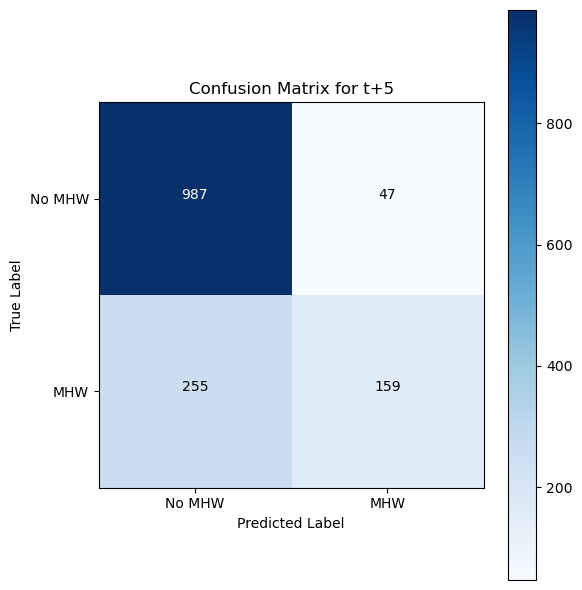

Confusion Matrix for forecast horizon t+6:
[[993  40]
 [293 122]]


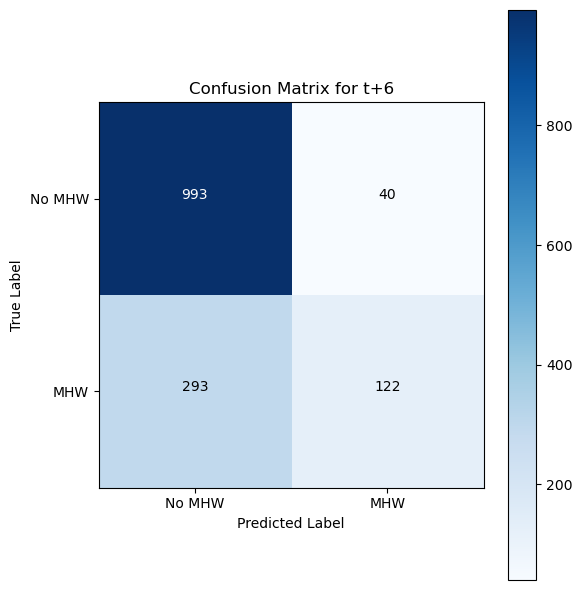

Confusion Matrix for forecast horizon t+7:
[[1002   30]
 [ 344   72]]


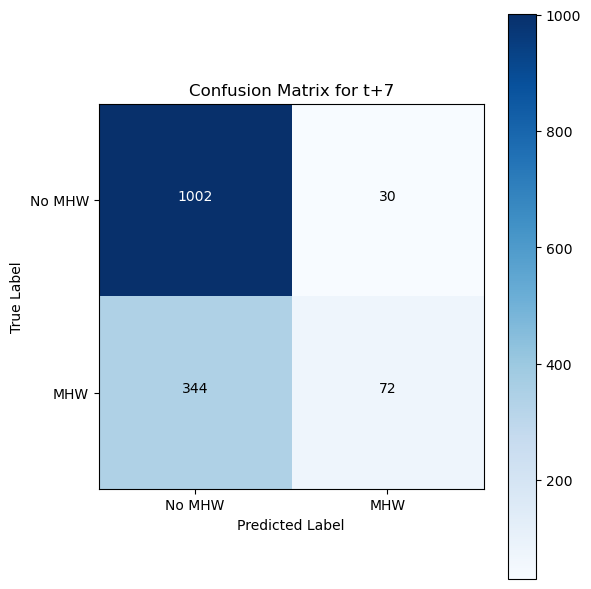

Precision  Recall (TPR)  F1 Score  Accuracy       FPR       TPR  \
Horizon                                                                    
t+1       0.911616      0.882641  0.896894  0.942680  0.033686  0.882641   
t+2       0.864162      0.731051  0.792053  0.891575  0.045236  0.731051   
t+3       0.826087      0.603912  0.697740  0.852210  0.050048  0.603912   
t+4       0.817121      0.513447  0.630631  0.830110  0.045236  0.513447   
t+5       0.771845      0.384058  0.512903  0.791436  0.045455  0.384058   
t+6       0.753086      0.293976  0.422877  0.770028  0.038722  0.293976   
t+7       0.705882      0.173077  0.277992  0.741713  0.029070  0.173077   

              FNR       FDR  
Horizon                      
t+1      0.117359  0.088384  
t+2      0.268949  0.135838  
t+3      0.396088  0.173913  
t+4      0.486553  0.182879  
t+5      0.615942  0.228155  
t+6      0.706024  0.246914  
t+7      0.826923  0.294118

In [22]:
# Evaluate metrics for each forecast horizon 
metrics_all = mhw_mb.evaluate_mhw_forecast_horizons(
    adjusted_test_time, y_test_inverted, yhat_test_inverted, train_t_1, train_sst_1, eda
)

df_metrics = mhw_mb.metrics_to_dataframe(metrics_all)
metrics_df_sl_mhw = df_metrics.copy()
df_metrics

### Comparative Analysis

In [23]:
rmse_results = {
    "Bay of Bengal": metrics_df_bay["RMSE"].values,
    "Gulf of Mannar": metrics_df_mannar["RMSE"].values,
    "Laccadive Sea": metrics_df_laccadive["RMSE"].values,
    "Sri Lankan Coast": metrics_df_sl["RMSE"].values
}


In [24]:
f1_results = {
    "Bay of Bengal": metrics_df_bay_mhw["F1 Score"].values,
    "Gulf of Mannar": metrics_df_mannar_mhw["F1 Score"].values,
    "Laccadive Sea": metrics_df_laccadive_mhw["F1 Score"].values,
    "Sri Lankan Coast": metrics_df_sl_mhw["F1 Score"].values
}


#### RMSE Plot Across all forecast horizons and Regions

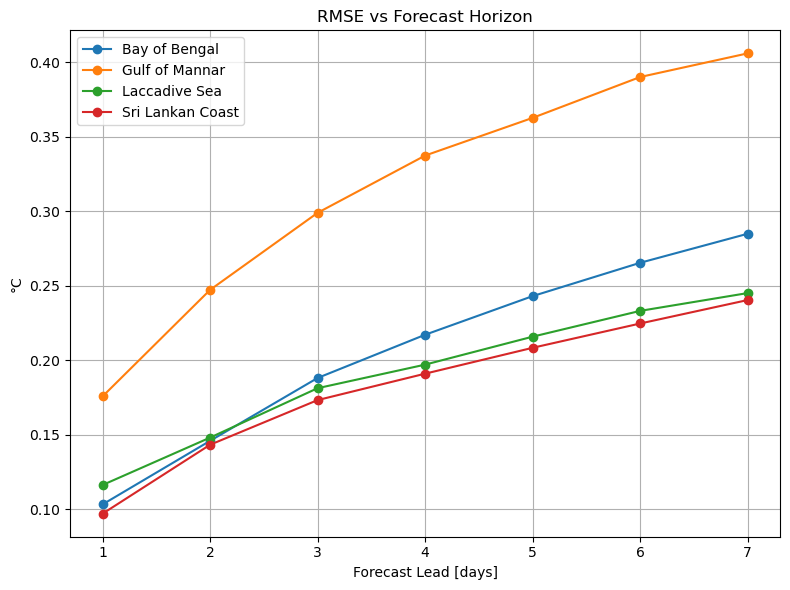

In [25]:
mhw_mb.plot_metric_by_region(rmse_results, metric_name="RMSE", ylabel="°C")


#### F1-Score Plot Across all forecast horizons and Regions

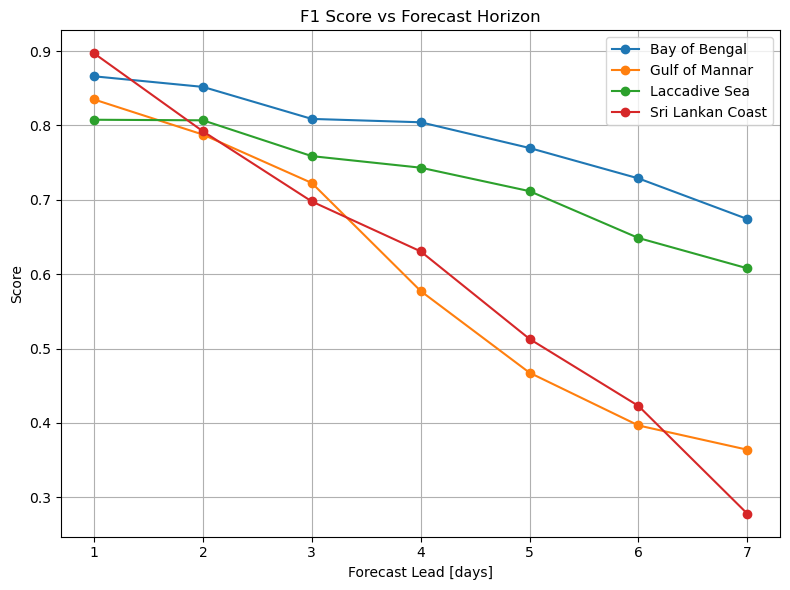

In [26]:
mhw_mb.plot_metric_by_region(f1_results, metric_name="F1 Score", ylabel="Score")


In [27]:
# Extract metric arrays for each region and metric
tpr_results = {
    "Bay of Bengal": metrics_df_bay_mhw["TPR"].values,
    "Gulf of Mannar": metrics_df_mannar_mhw["TPR"].values,
    "Laccadive Sea": metrics_df_laccadive_mhw["TPR"].values,
    "Sri Lankan Coast": metrics_df_sl_mhw["TPR"].values
}

tnr_results = {
    "Bay of Bengal": 1 - metrics_df_bay_mhw["FPR"].values,  # TNR = 1 - FPR
    "Gulf of Mannar": 1 - metrics_df_mannar_mhw["FPR"].values,
    "Laccadive Sea": 1 - metrics_df_laccadive_mhw["FPR"].values,
    "Sri Lankan Coast": 1 - metrics_df_sl_mhw["FPR"].values
}

fpr_results = {
    "Bay of Bengal": metrics_df_bay_mhw["FPR"].values,
    "Gulf of Mannar": metrics_df_mannar_mhw["FPR"].values,
    "Laccadive Sea": metrics_df_laccadive_mhw["FPR"].values,
    "Sri Lankan Coast": metrics_df_sl_mhw["FPR"].values
}

fnr_results = {
    "Bay of Bengal": metrics_df_bay_mhw["FNR"].values,
    "Gulf of Mannar": metrics_df_mannar_mhw["FNR"].values,
    "Laccadive Sea": metrics_df_laccadive_mhw["FNR"].values,
    "Sri Lankan Coast": metrics_df_sl_mhw["FNR"].values
}


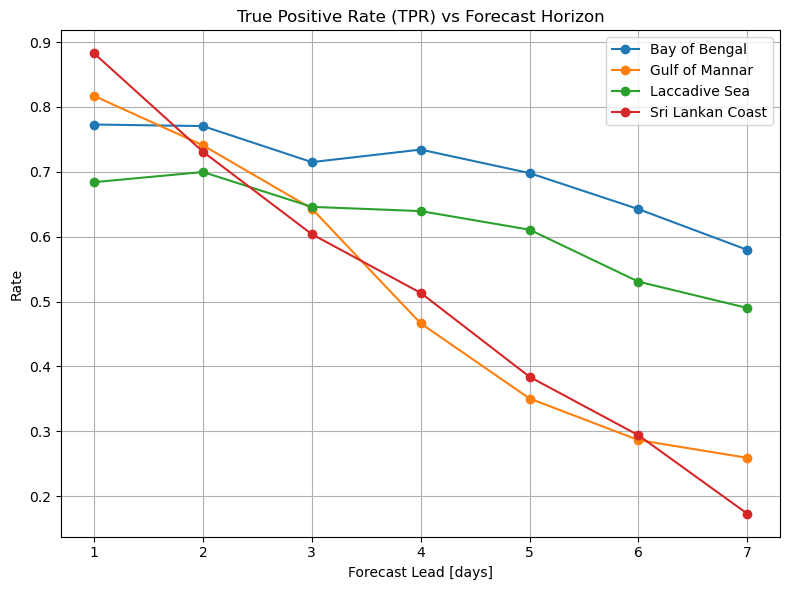

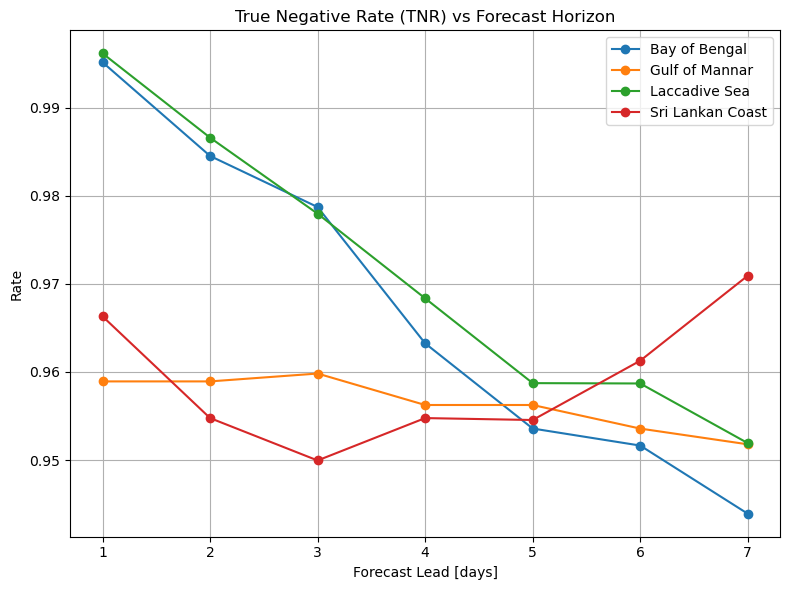

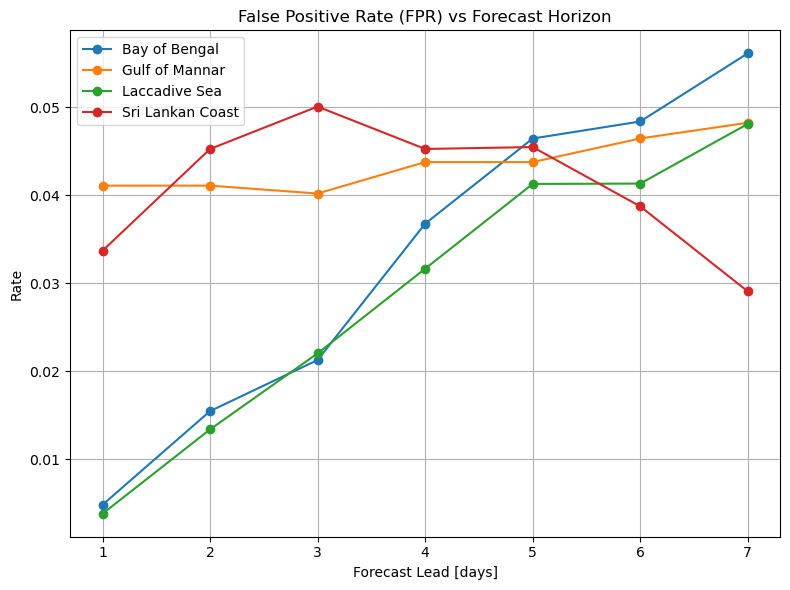

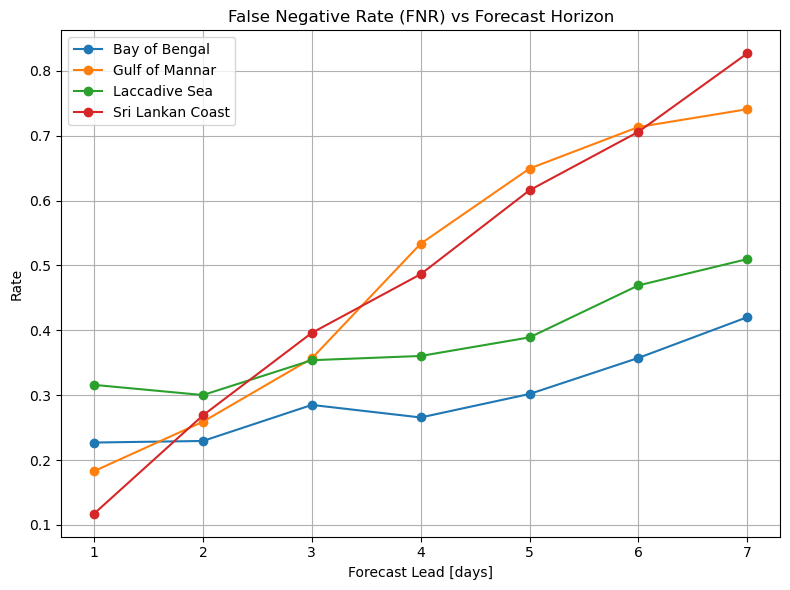

In [28]:
mhw_mb.plot_metric_by_region(tpr_results, metric_name="True Positive Rate (TPR)", ylabel="Rate")
mhw_mb.plot_metric_by_region(tnr_results, metric_name="True Negative Rate (TNR)", ylabel="Rate")
mhw_mb.plot_metric_by_region(fpr_results, metric_name="False Positive Rate (FPR)", ylabel="Rate")
mhw_mb.plot_metric_by_region(fnr_results, metric_name="False Negative Rate (FNR)", ylabel="Rate")
